# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pymystem3 import Mystem
from IPython.display import display
from collections import Counter
from collections import OrderedDict
m = Mystem()
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
display(data.head(10))
display(data.info())
import warnings
warnings.simplefilter('ignore')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

None

### Вывод

Полученные данные выглядят приемлимо, однако не обошлось и без артефактов. Первым, что бросилось в глаза - необходимость введения аргумента "разделитель" для корректного отображения таблицы данных. Далее, по какой-то причине утрачена информация о времени размещения объявлений, однако дата везде указана корректно, формат даты также верен. Конкретное время размещения объявления - величина не столь важная, так что для простоты анализа самым логичным будет её просто опустить, оставишь лишь дату. Кроме того, встречается большое количесвто пропусков, в разных колонках. Какие пропуски стоит заполнить, а какие отбраковать еще предстоит разобраться.

### Шаг 2. Предобработка данных

In [2]:
def date_correction(date):
    date = pd.to_datetime(date).round('1D')
    return date

data['first_day_exposition'] = data['first_day_exposition'].apply(date_correction)

data['balcony'] = data['balcony'].fillna('0')

data['ceiling_height'] = data['ceiling_height'].round(1)

data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

for row in range(len(data)):
    if data.loc[row,'ceiling_height'] < 2.5 or data.loc[row,'ceiling_height']> 30:
        data.loc[row,'ceiling_height'] = data['ceiling_height'].median()
    if data.loc[row,'ceiling_height'] > 6 and data.loc[row,'ceiling_height'] < 25:
        data.loc[row,'ceiling_height'] = data['ceiling_height'].median()
    if data.loc[row,'ceiling_height'] >= 25 and data.loc[row,'ceiling_height'] <= 30:
        data.loc[row,'ceiling_height'] = data.loc[row,'ceiling_height']/10

data['is_apartment'] = data['is_apartment'].fillna('False')

def lemmatization(text):
    lemmas = m.lemmatize(text)
    text = ' '.join(lemmas)
    return text

data['locality_name'] = data['locality_name'].fillna('данные отсутствуют')

data['locality_name'] = data['locality_name'].apply(lemmatization)

list_for_count = [string.split(' ') for string in data['locality_name'].values]

def lemmatised_counter(list_of_lemmas): 
    lemmatised_names=[]
    for row in list_of_lemmas:
        for col in row:
            lemmatised_names.append(col)
    return lemmatised_names

lemmatised_list = lemmatised_counter(list_for_count)

summ_of_lemmas = Counter(lemmatised_list) 

summ_of_lemmas_sorted_by_value = OrderedDict(sorted(summ_of_lemmas.items(), key=lambda x: x[1], reverse = True))

#display(summ_of_lemmas_sorted_by_value)
# выводим в проядке убывания количества упоминаний леммы и ищем в них названия 10 самых частовстречающихся
#в объявлениях городов для последующего анализа

def name_changes(names):
    if "санкт-петербург" in names:
        return 'санкт-петербург'
    if "муриный" in names:
        return 'мурино'
    if "кудрово" in names:
        return 'кудрово'
    if "шушар" in names:
        return 'шушары'
    if "всеволожск" in names:
        return 'всеволожск'
    if "пушкин" in names:
        return 'пушкин'
    if "колпино" in names:
        return 'колпино'
    if "парголовый" in names:
        return 'парголово'
    if "гатчина" in names:
        return 'гатчина'
    if "выборг" in names:
        return 'выборг'
    if "петергоф" in names:
        return 'петергоф'
    else:
        return 'прочие населенные пункты'

data['locality_name'] = data['locality_name'].apply(name_changes)

data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median().round(0))

data['living_area'] = data['living_area'].fillna(0)
data['kitchen_area'] = data['kitchen_area'].fillna(0)

coef1 = (data['total_area'].median())/(data['kitchen_area'].median())
coef2 = (data['total_area'].median())/(data['living_area'].median())

def living_area_correction(total_area, living_area):
    if living_area == 0:
        living_area = total_area/coef2
        return living_area.round(1)
    else:
         return living_area
    
def kitchen_area_correction(total_area, kitchen_area):
    if kitchen_area == 0:
        kitchen_area = total_area/coef1
        return kitchen_area.round(1)
    else:
        return kitchen_area

for row in range(len(data)):
    data.loc[row, 'living_area'] = living_area_correction(data.loc[row, 'total_area'], data.loc[row, 'living_area'])
    data.loc[row, 'kitchen_area'] = kitchen_area_correction(data.loc[row, 'total_area'], data.loc[row, 'kitchen_area'])

current_date = datetime.datetime.today()
#display(current_date)
data['days_exposition'] = data['days_exposition'].fillna(0)
for row in range(len(data)):
    if data.loc[row, 'days_exposition'] == 0:
        data.loc[row, 'days_exposition'] = (current_date - data.loc[row, 'first_day_exposition']).days 

#display(data.query('total_area <= kitchen_area + living_area')) #проверка правильности заполнения пропусков
data['last_price'] = data['last_price']/1000000
data = data.astype({'floors_total': 'int64', 'balcony': 'int64', 'is_apartment': 'bool', 'days_exposition': 'int64'})

display(data.head(10))
display(data.info())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13.000,108.00,2019-03-07,3,2.7,16,51.00,8,True,False,False,25.00,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,934
1,7,3.350,40.40,2018-12-04,1,2.6,11,18.60,1,True,False,False,11.00,2,шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81
2,10,5.196,56.00,2015-08-20,2,2.6,5,34.30,4,True,False,False,8.30,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558
3,0,64.900,159.00,2015-07-24,3,2.6,14,88.70,9,True,False,False,27.50,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424
4,2,10.000,100.00,2018-06-19,2,3.0,14,32.00,13,True,False,False,41.00,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121
5,10,2.890,30.40,2018-09-10,1,2.6,12,14.40,5,True,False,False,9.10,0,прочие населенные пункты,NaN,NaN,NaN,NaN,NaN,NaN,55
6,6,3.700,37.30,2017-11-02,1,2.6,26,10.60,6,True,False,False,14.40,1,парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155
7,5,7.915,71.60,2019-04-18,2,2.6,24,39.90,22,True,False,False,18.90,2,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,892
8,20,2.900,33.16,2018-05-23,1,2.6,27,15.43,26,True,False,False,8.81,0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,189
9,18,5.400,61.00,2017-02-26,3,2.5,9,43.60,7,True,False,False,6.50,2,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around

None

Значения, которые стоило подправлять - исправлены. В первую очередь, я избавился от пустых значений точного времени размещения объявления, эти значения для анализа не нужны, а угадывать их - трата времени. Далее, я исправил пустые значения в строке "балконы" их отсутствие может говорить о двух варинтах развития событий, или это шибка заполнения, или балково в таких квартирах попросту нет. Угадывать наличие или отсутствие балкона - дело неблагодарное, так что для упрощения задачи мы просто будем считать, что балконов в указанных квартирах нет.

Следущим шагом я сделал обработку столбца с высотой потолков. Самая большая высота в домах старого фонда СПб примерно 6 метров, а значит что значения больше указанного - явная ошибка. Так как ошибки были разного характера(например, 25ти метровый потолок это, скорее всегда, 2.5ти метровый потолок, ошибка при заполнении данных в месте постановки запятой), эту корректировку я сделал через цикл, заменяющий явно выбивающиеся значение на более корректные.

Следующий этоп - обработка строк с названием города. "Поселок Шушары", "посёлок Шушары" и "Шушары" - один и тот же аселенный пункт, значит настало время лемматизации. Для упрощения нахождения зависимостей далее я сразу выделил топ 10 населенных пунктов по количеству объявлений и заменил неудобные названия на простые леммы, остальные населенные пункты объеденены в группу "прочие населенные пункт", этим же значением заполнены попуски, так как угадать по прочим признакам город как минимум очень сложно.

Количество этажей в доме я заменил на медианное значение, окрегленное до целого(в доме не может быть 15.5 этажей). Пропусков в этой колонке было очень мало, что позволяет гарантировать репрезентативность выборки для последующего анализа. 

Переходим к отсутствующим значениям в жилой площади и площади кухни. Для корректировки пропусков в этих столбцах я использовал нормировочные коэффициенты и заполнял пропуски ссылаясь на них в зависимости от общей площади квартиры, поэтому ситуаций, когда сумма площадей в ячейках, которые мы заполнили, не может превышать общую. 

Последним шагом я откорретировал пропуски в колонке количества дней до момента снятия объявления с публикации. Отсутсвие значений тут говорит нам о том, что объявление, скорее всего, до сих пор опубликовано, поэтому я заменил пустые ячеки на разницу между временем публикации объявления и текущей датой. 

Остались незаполненными столбцы с информацией о расстояниях до ключевых объектов. Они намеренно незаполненны. Во-первых, угадывать или вычислять вручную такие приззнаки - слишком долгая и неблагодарная работа. Во-вторых, имеющихся значений вполне достаточно, чтобы попробовать вычислить зависимость времени на продажу квартиры от этих факторов.

Последнее действие в этом блоке - замена необходимых типов данных. Первая замена произошла при форматировании даты, там тип данных с object я поменял на datetime64. Кроме того, колонки с указанием общего числа этажей и количества балконов я заменил на целочисленный тип данных, так как эти показатели не могут быть дробными. Столбец, показывающий принадлежность к апартаментам я сделал булиевым, так как меня интересует исключительно являются ли объявления апартаментами или нет, никаких строковых комментариев в этом столбце быть не должно.

### Шаг 3. Посчитайте и добавьте в таблицу

In [10]:
data['square_meter_prise'] = (data['last_price']/data['total_area']).round(1)
data['weekday_published'] = data['first_day_exposition'].dt.weekday
data['month_published'] = data['first_day_exposition'].dt.month
data['year_published'] = data['first_day_exposition'].dt.year

def floor(floor, max_floor):
    if floor ==1:
        return 'первый'
    if floor == max_floor:
        return 'последний'
    else:
        return 'другой'

for row in range(len(data)):
    data.loc[row, 'floor_mark'] = floor(data.loc[row, 'floor'], data.loc[row, 'floors_total'])

data['living_area_in_percent'] = round((data['living_area']/data['total_area'])*100, 2)
data['kitchen_area_in_percent'] = round((data['kitchen_area']/data['total_area'])*100, 2)
#display(data['rooms'].unique())
#display(data['weekday_published'].unique())
display(data.head(10))
display(data.info())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_prise,weekday_published,month_published,year_published,floor_mark,living_area_in_percent,kitchen_area_in_percent
0,20,13.000,108.00,2019-03-07,3,2.7,16,51.00,8,True,False,False,25.00,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,934,0.1,3,3,2019,другой,47.22,23.15
1,7,3.350,40.40,2018-12-04,1,2.6,11,18.60,1,True,False,False,11.00,2,шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,0.1,1,12,2018,первый,46.04,27.23
2,10,5.196,56.00,2015-08-20,2,2.6,5,34.30,4,True,False,False,8.30,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,0.1,3,8,2015,другой,61.25,14.82
3,0,64.900,159.00,2015-07-24,3,2.6,14,88.70,9,True,False,False,27.50,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,0.4,4,7,2015,другой,55.79,17.30
4,2,10.000,100.00,2018-06-19,2,3.0,14,32.00,13,True,False,False,41.00,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,0.1,1,6,2018,другой,32.00,41.00
5,10,2.890,30.40,2018-09-10,1,2.6,12,14.40,5,True,False,False,9.10,0,прочие населенные пункты,NaN,NaN,NaN,NaN,NaN,NaN,55,0.1,0,9,2018,другой,47.37,29.93
6,6,3.700,37.30,2017-11-02,1,2.6,26,10.60,6,True,False,False,14.40,1,парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155,0.1,3,11,2017,другой,28.42,38.61
7,5,7.915,71.60,2019-04-18,2,2.6,24,39.90,22,True,False,False,18.90,2,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,892,0.1,3,4,2019,другой,55.73,26.40
8,20,2.900,33.16,2018-05-23,1,2.6,27,15.43,26,True,False,False,8.81,0,мурино,NaN,NaN,NaN,NaN,NaN,NaN,189,0.1,2,5,2018,другой,46.53,26.57
9,18,5.400,61.00,2017-02-26,3,2.5,9,43.60,7,True,False,False,6.50,2,санкт-петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289,0.1,6,2,2017,другой,71.48,10.66


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 29 columns):
total_images               23699 non-null int64
last_price                 23699 non-null float64
total_area                 23699 non-null float64
first_day_exposition       23699 non-null datetime64[ns]
rooms                      23699 non-null int64
ceiling_height             23699 non-null float64
floors_total               23699 non-null int64
living_area                23699 non-null float64
floor                      23699 non-null int64
is_apartment               23699 non-null bool
studio                     23699 non-null bool
open_plan                  23699 non-null bool
kitchen_area               23699 non-null float64
balcony                    23699 non-null int64
locality_name              23699 non-null object
airports_nearest           18157 non-null float64
cityCenters_nearest        18180 non-null float64
parks_around3000           18181 non-null float64
park

None

### Шаг 4. Проведите исследовательский анализ данных

count    23699.000000
mean         6.541549
std         10.887013
min          0.012190
25%          3.400000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price, dtype: float64

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

count    23699.000000
mean         2.680714
std          0.226312
min          2.500000
25%          2.600000
50%          2.600000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64

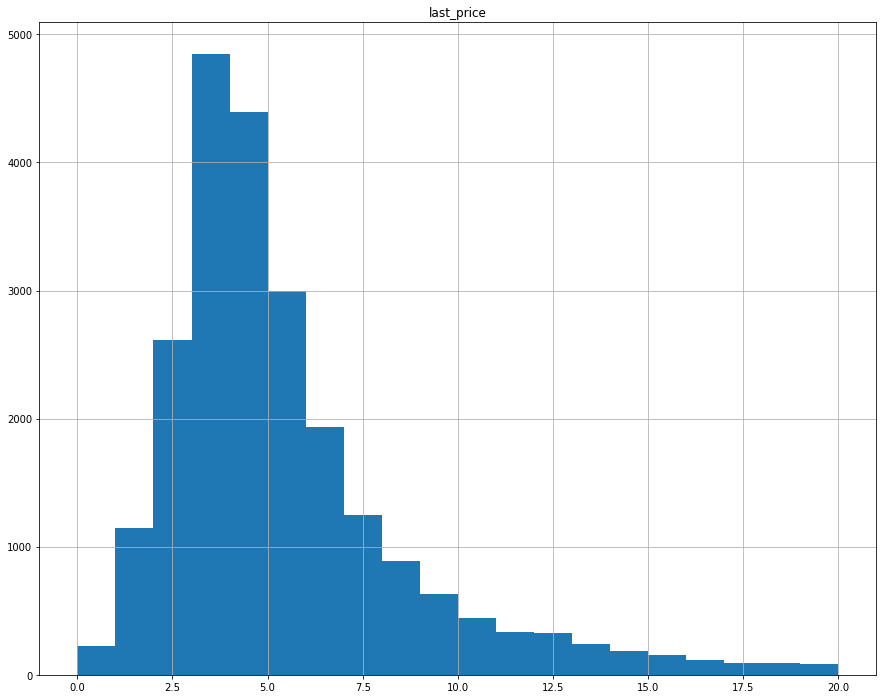

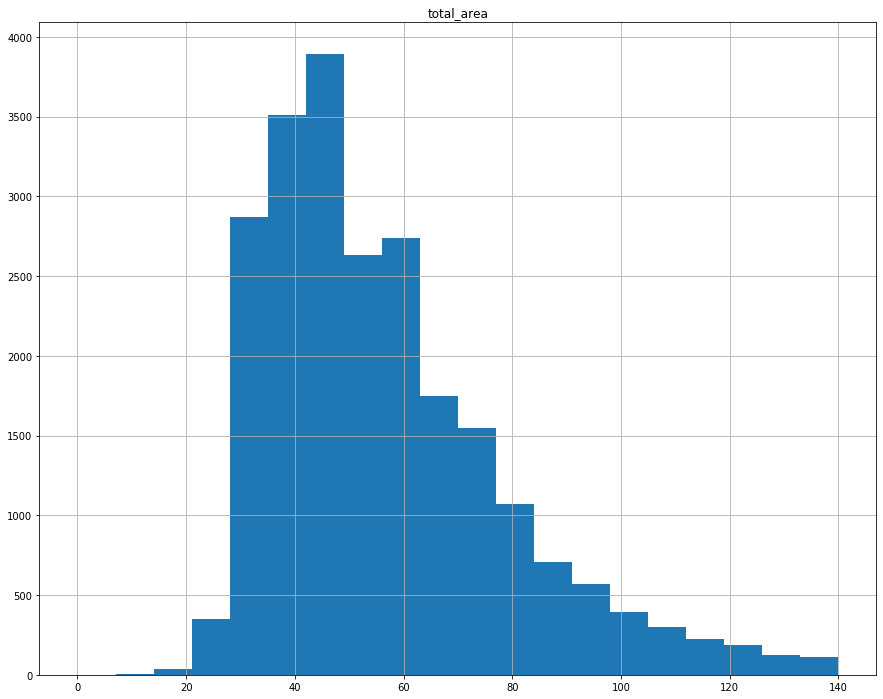

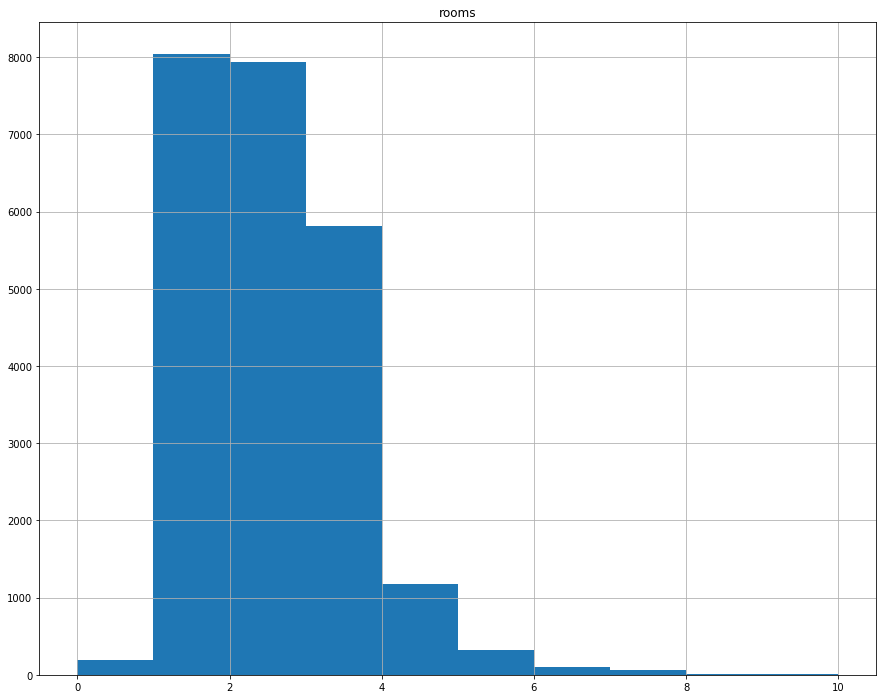

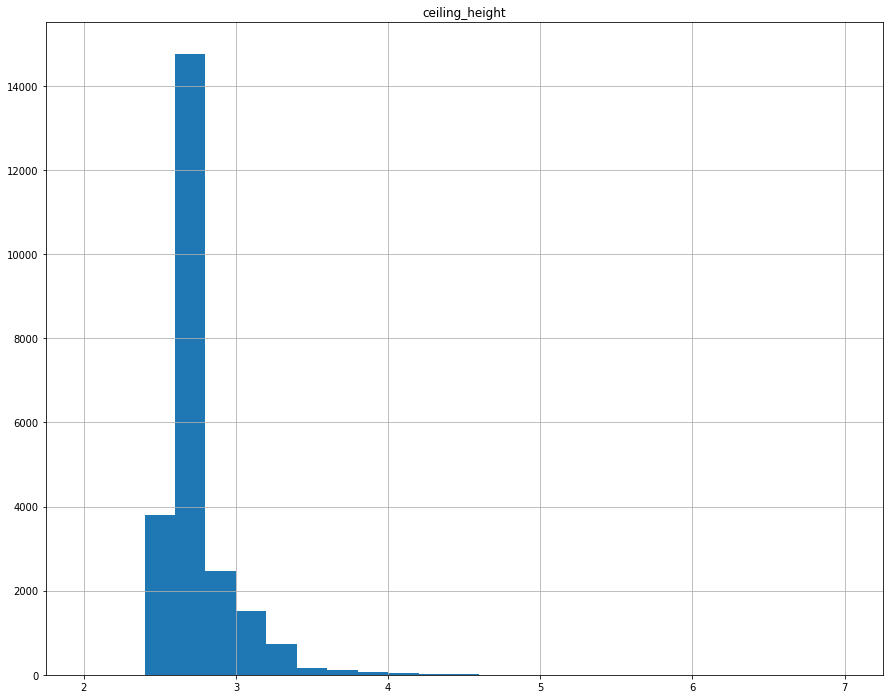

In [11]:
display(data['last_price'].describe())
display(data['total_area'].describe())
display(data['rooms'].describe())
display(data['ceiling_height'].describe())

data.hist('last_price', bins = 20, range = (0, 20), figsize = (15,12))
plt.show()
data.hist('total_area', bins = 20, range = (0, 140), figsize = (15,12))
plt.show()
data.hist('rooms', bins = 10, range = (0, 10), figsize = (15,12))
plt.show()
data.hist('ceiling_height', bins = 25, range = (2, 7), figsize = (15,12))
plt.show()


На полученных гистограммах стоит отметить следующие интересные наблюдения: гистограмма распределения цен показывает, что большая часть значений сосредоточена вокруг примерно 20ти миллионов за квартиру, поэтому сузим интервал отображения гистограммы до 20. Новая гистограмма уточнила нашу гипотезу, самые продаваемые квартиры стоили около 3-4 млн руб. Аналогичным образом отбросим хвост диаграммы общей площади для более подробного анализа. Оказывается, что наиболее продаваемые квартиры были площадью примерно 40-45 квадратных метров, что, в целом, соответствует действительности(средняя площади однокомнатной квартиры) и самым популярным ценам, полученным из анализа первой гистограммы. Кроме отмеченного, наблюдается небольшой пик вокруг значения площади 60 квадратных метров - один из самых распространенных типов двухкомнатных квартир, поэтому аномальным этот всплеск назвать нельзя, общая картина близка к реальной. Гистограмма распределения количества комнат снова подтверждает уточненную гипотезу - самые популярные квартиры на продажу - одно и двухкомнатные. Трёхкомнатные квартира старого фонда тоже бывают в районе 60ти квадратных метров, так что пока гипотеза кажется верной, полученные зависимости ей не противоречат. А вот квартиры с большей площадью и количеством комнат пользуются ощутимо меньшей популярностью ввиду высокой цены. Перейдем к анализа гистограммы распределения высоты потолков. самые продаваемые квартиры расположились в интервале от 2,5 до 2,8 метров(примерно). Такая высота соответствует домам старого фонда и большинству бюджетных новостроек, что еще раз подтверждает нашу гипотезу.

count    23699.000000
mean       303.537111
std        389.026272
min          1.000000
25%         45.000000
50%        124.000000
75%        390.000000
max       2495.000000
Name: days_exposition, dtype: float64

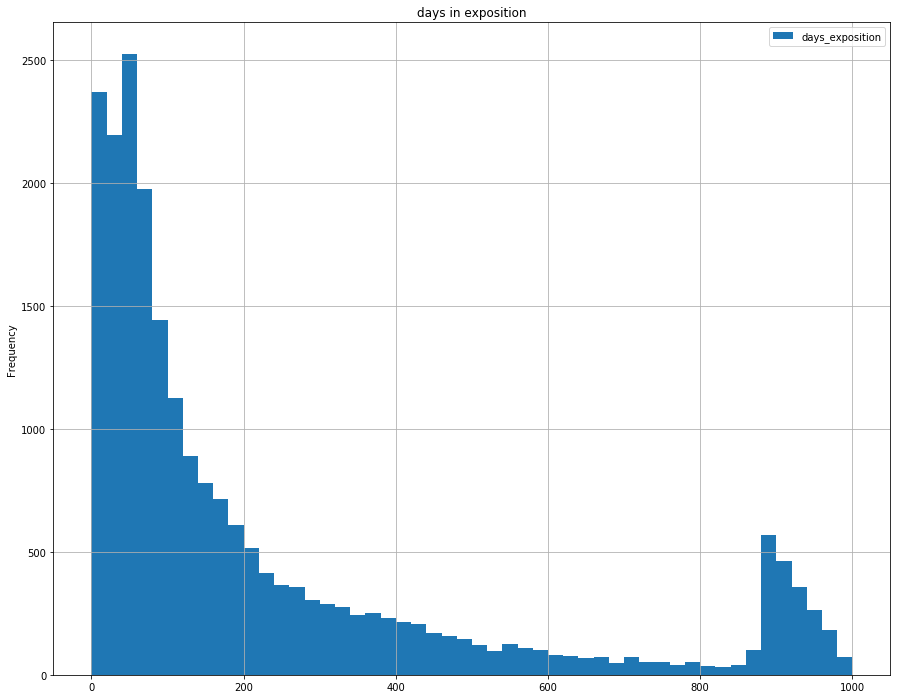

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18468 entries, 1 to 23695
Data columns (total 29 columns):
total_images               18468 non-null int64
last_price                 18468 non-null float64
total_area                 18468 non-null float64
first_day_exposition       18468 non-null datetime64[ns]
rooms                      18468 non-null int64
ceiling_height             18468 non-null float64
floors_total               18468 non-null int64
living_area                18468 non-null float64
floor                      18468 non-null int64
is_apartment               18468 non-null bool
studio                     18468 non-null bool
open_plan                  18468 non-null bool
kitchen_area               18468 non-null float64
balcony                    18468 non-null int64
locality_name              18468 non-null object
airports_nearest           14212 non-null float64
cityCenters_nearest        14232 non-null float64
parks_around3000           14232 non-null float64
park

None

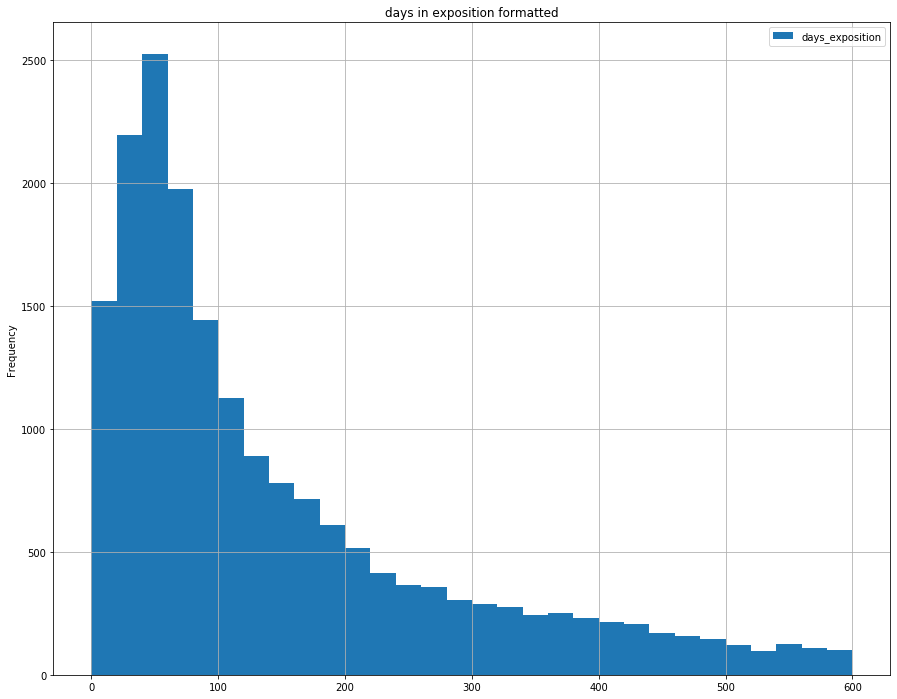

In [12]:
display(data['days_exposition'].describe())
data.plot(y = 'days_exposition', title = 'days in exposition',kind = 'hist', bins = 50, range = (0, 1000), grid = True, legend = True, figsize = (15,12))
plt.show()
data_formated = data.query('days_exposition < 600 and days_exposition > 7')
display(data_formated.info())
data_formated.plot(y = 'days_exposition', title = 'days in exposition formatted',kind = 'hist', bins = 30, range = (0, 600), grid = True, legend = True, figsize = (15,12))
plt.show()

Анализируя сроки продаж квартир обнаружилось два аномальных всплеска, первый вокруг нуляб второй в районе 700 дней с момента размещения объявления. Первый всплеск - явная аномалия, чисто технически очень сложно продать квартиру меньше, чем за неделю, на практике речь идет о большем сроке. Скорее всего, такие объявления были сняты с публикации на площадке яндекс.недвижимости и либо размещены где-либо еще, либо были размещены где либо еще предварительно, а яндекс.недвижимость стала "запасным" вариантом, который "не сыграл". Либо это какой-то внутренний баг системы. В любом случае, такие значения стоит отфильтровать. Второй всплеск можно интерпретировать по разному. С одной стороны, причина резкого скачка в хвосте распределения может быть вызвана из-за выбранного метода заполнения данными пропущенных значений. С другой - возможным банкротством крупной компании застройщика, в таком случае большую часть незавершенных им объектов могли выставить на продажу по переуступкам или как-либо еще. Если это произошло пару лет назад, а дела у объектов в гору не пошли такой всплеск мог бы быть объяснен подобным образом(тем более, что пару лет назад был такой застройщик в СПб, назывался он Норманн и как раз обанкротился,так и не завершив даже уже начатые объекты). Такие значения тоже стоит отбраковать. После удаления выбросов получился график очень напоминающий распределение Пуансона, которое, как раз, описывает вероятность события в еденицу времени. А значит, данные были отфильтрованы верно и полученная выборка более репрезентативна. Продолжим анализ с ней.

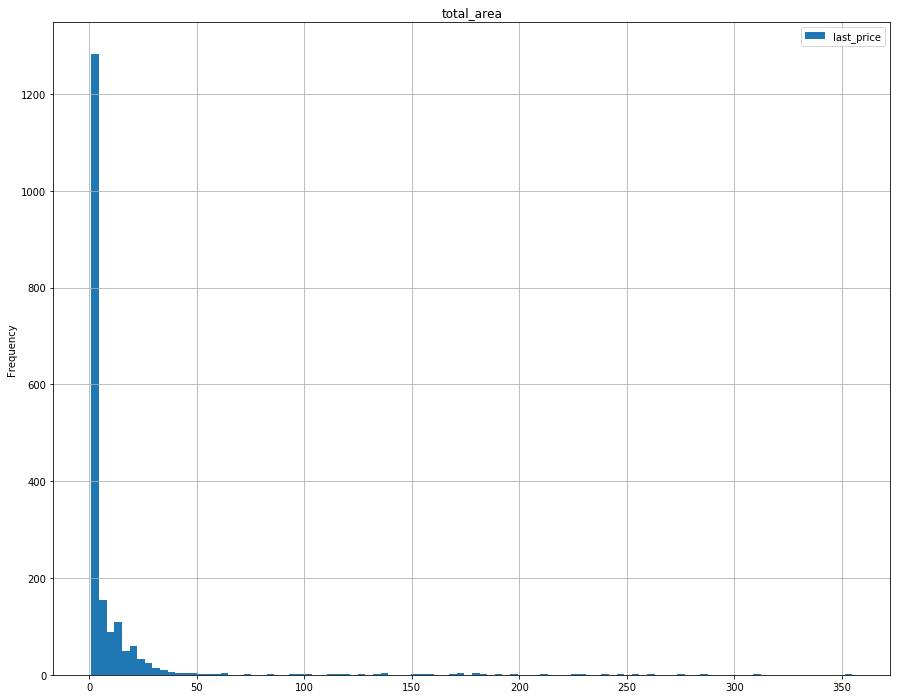

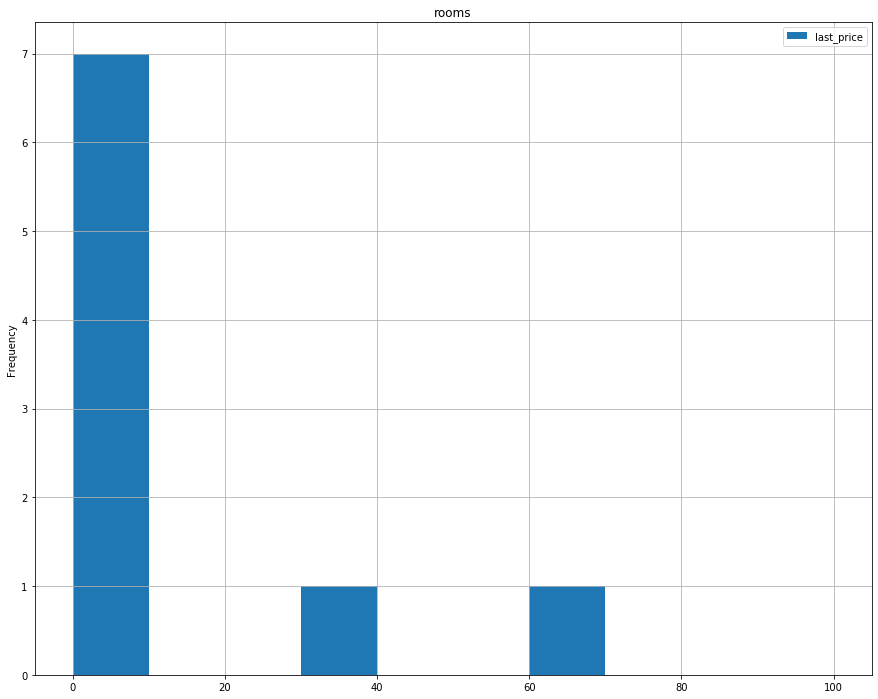

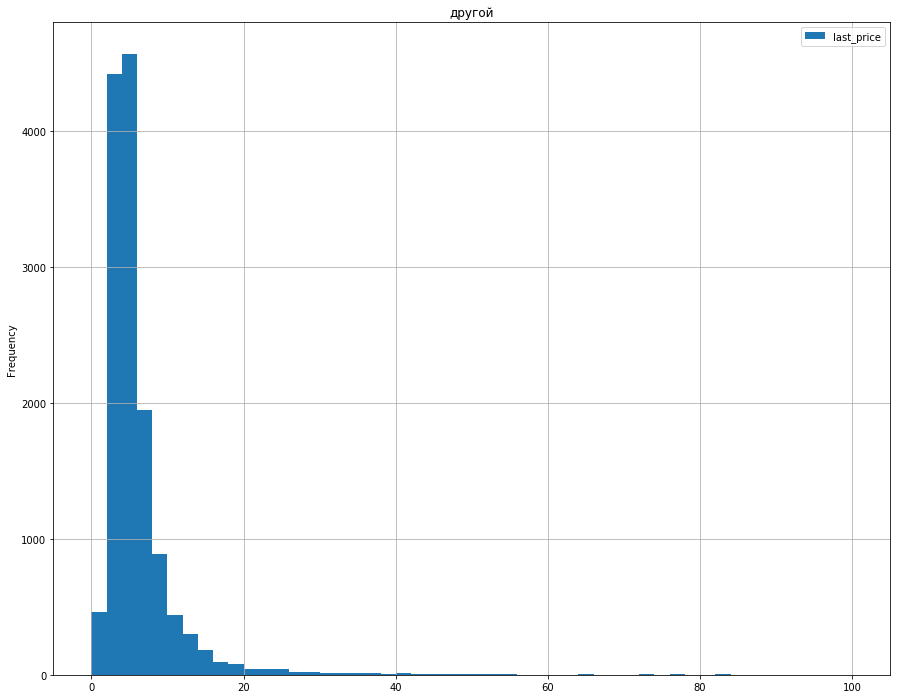

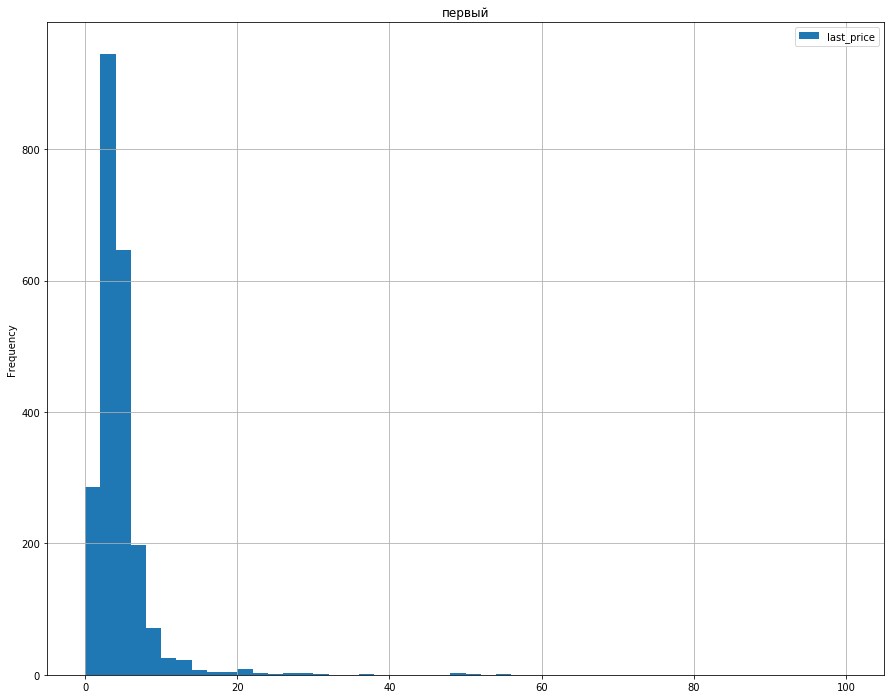

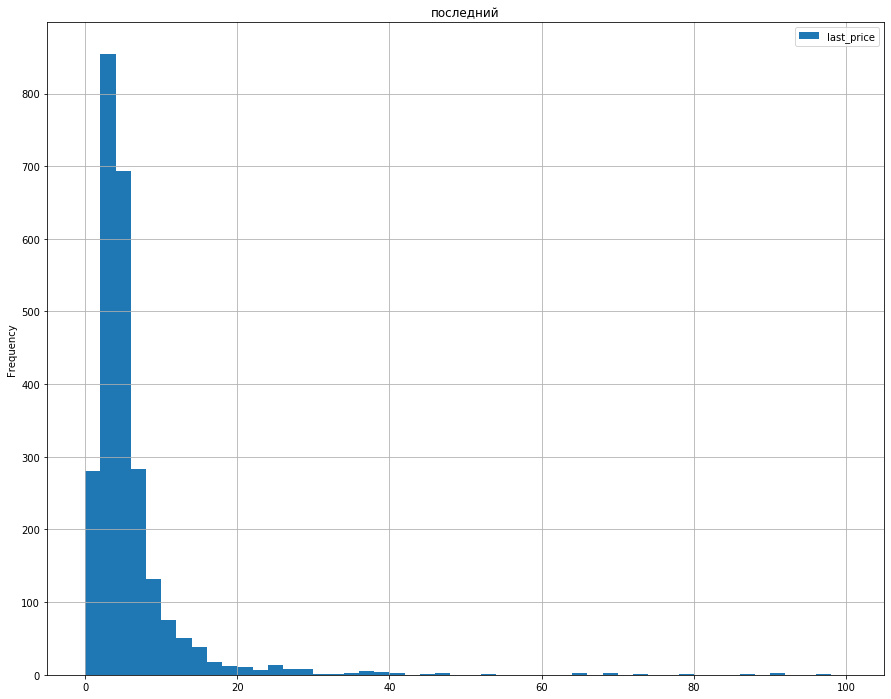

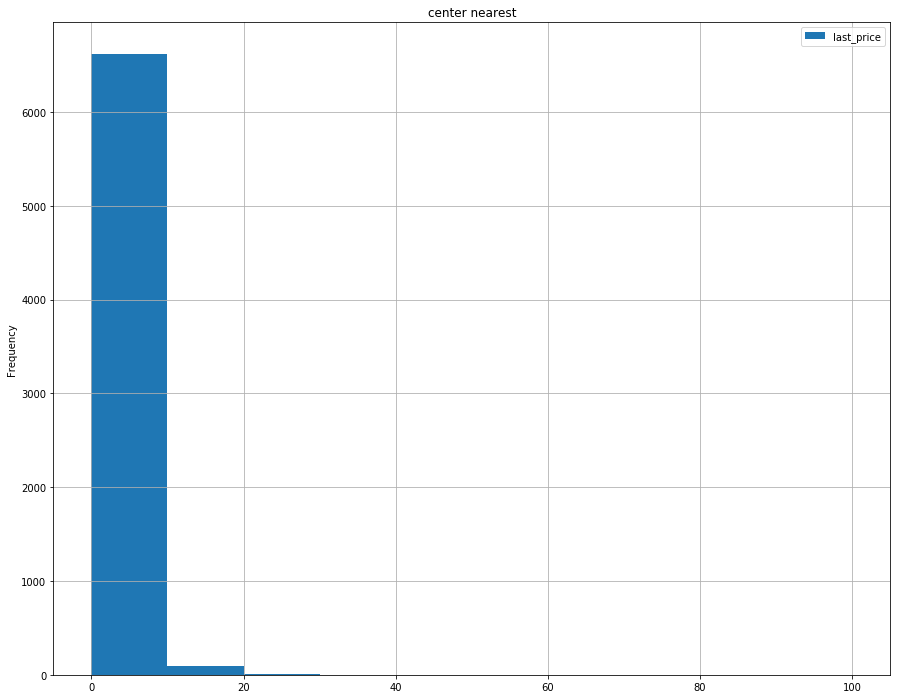

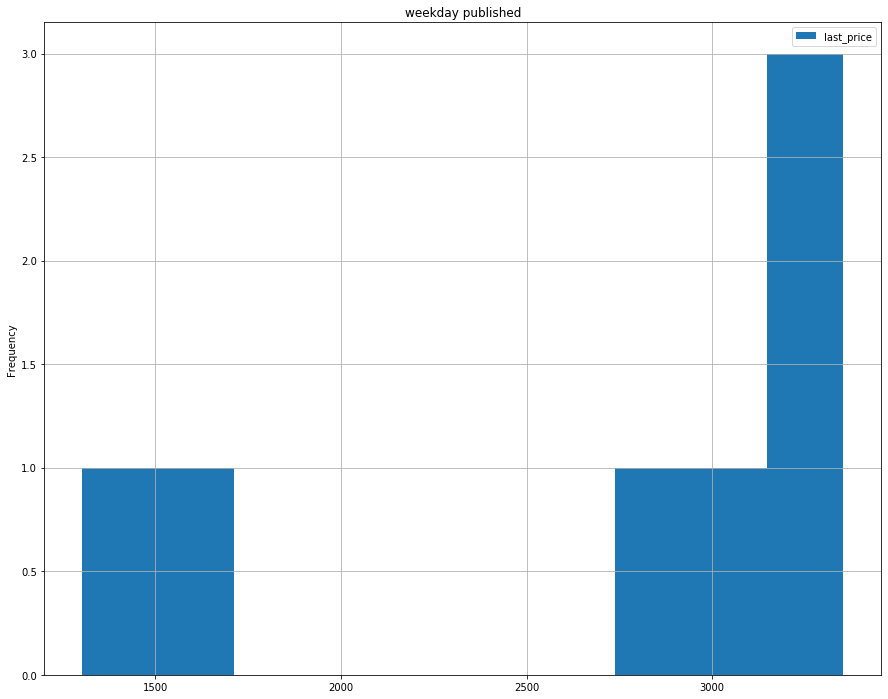

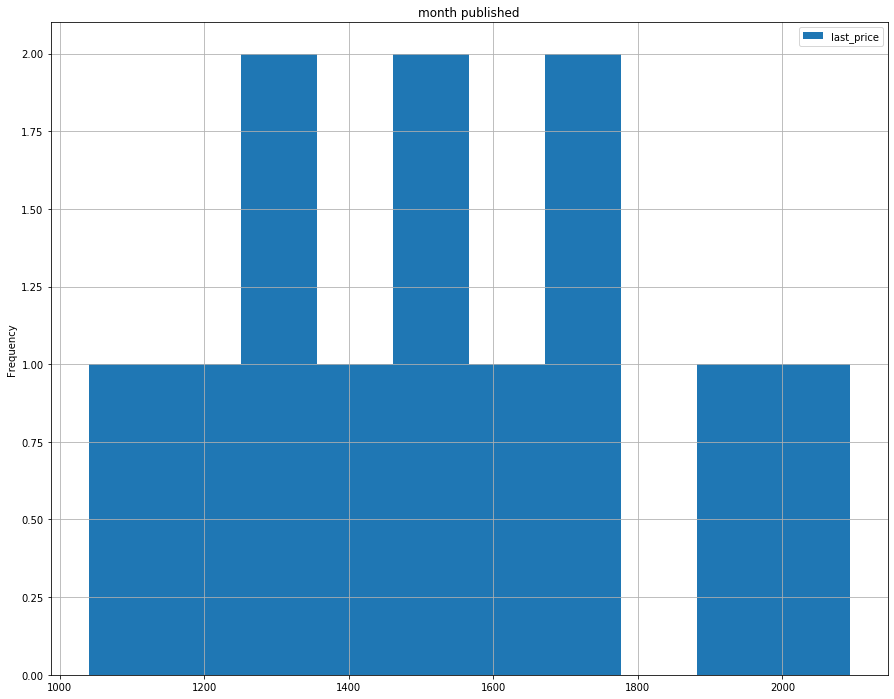

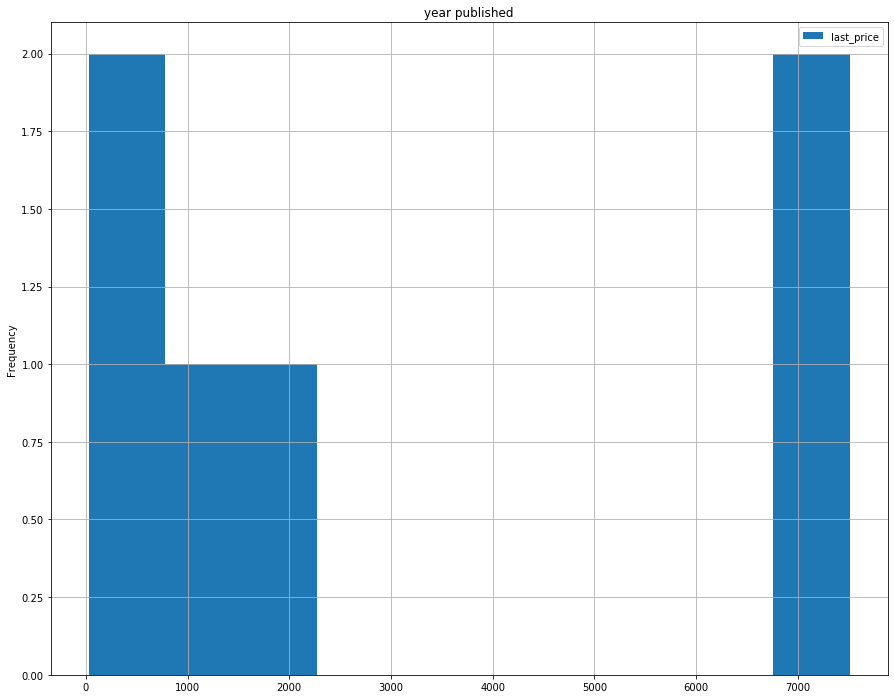

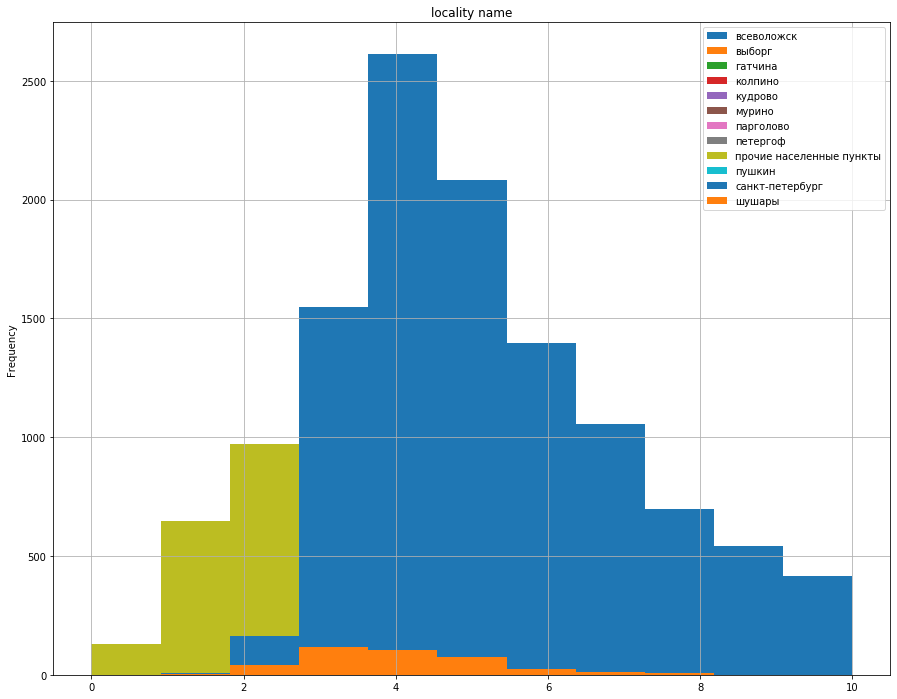

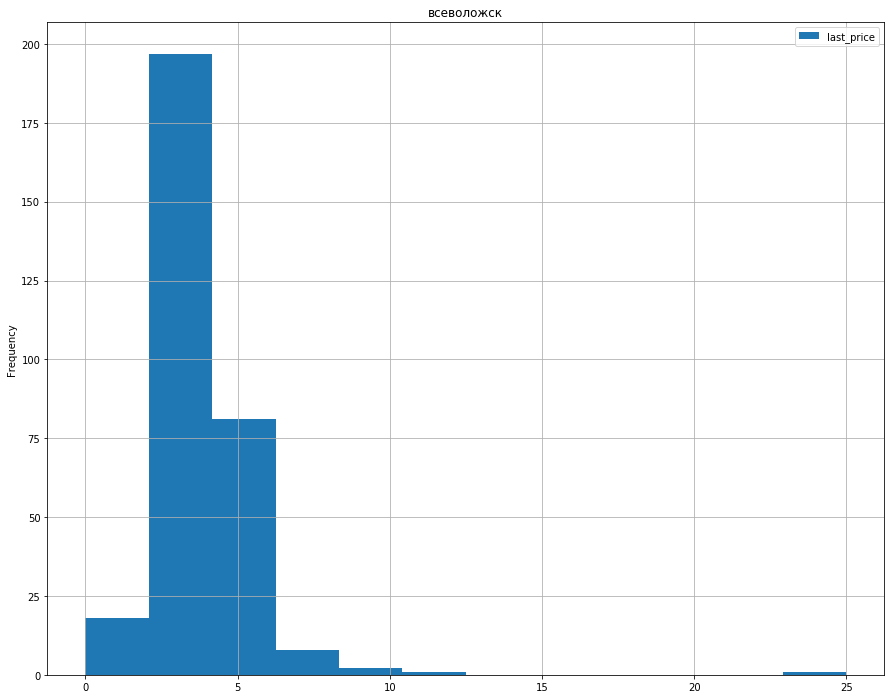

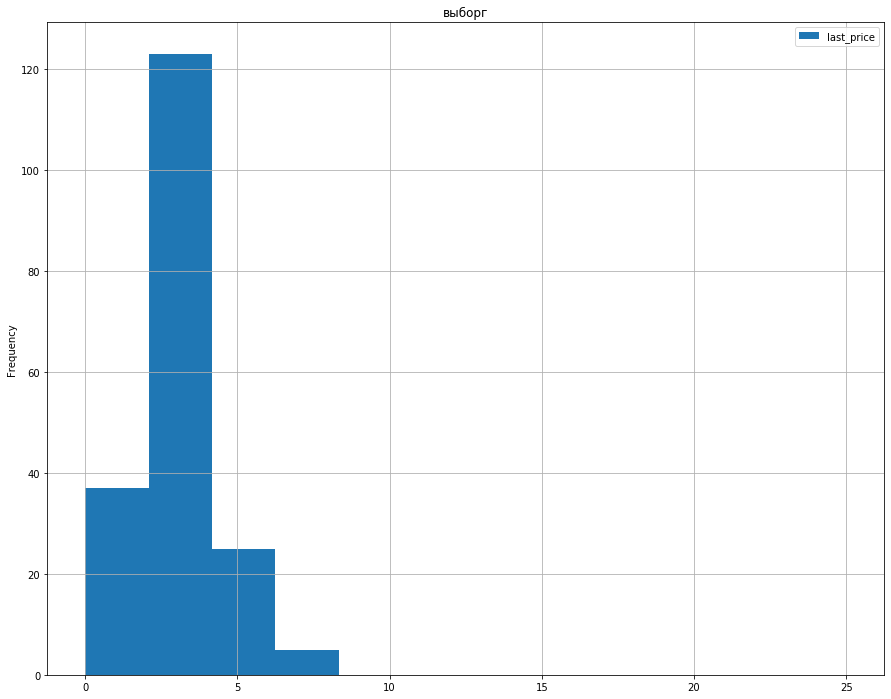

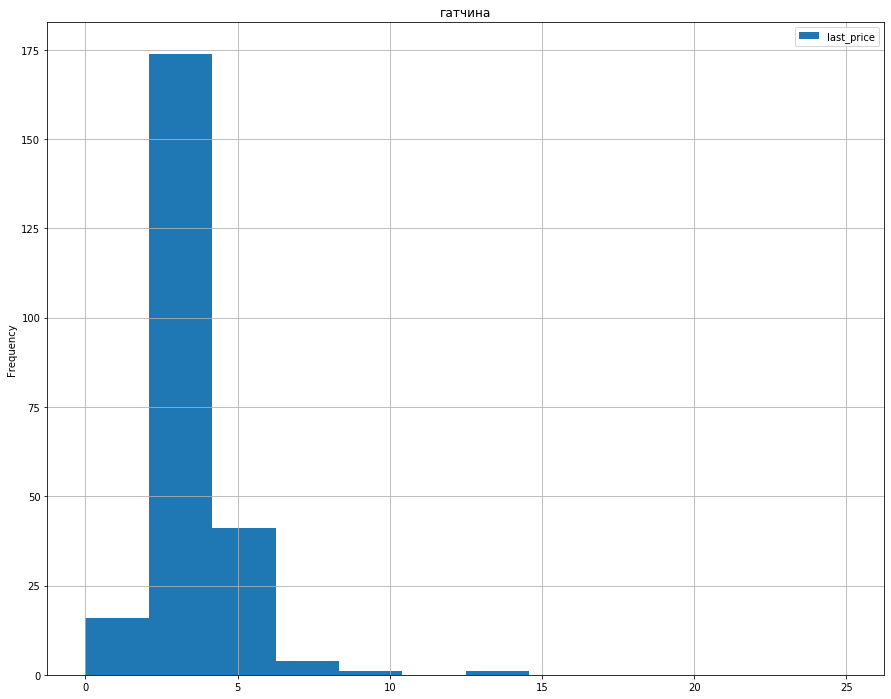

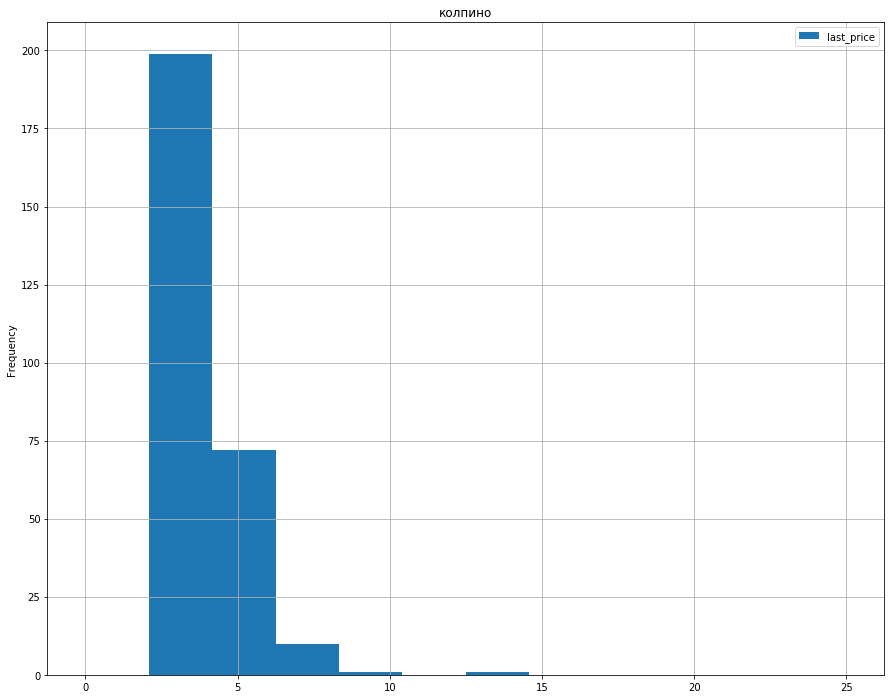

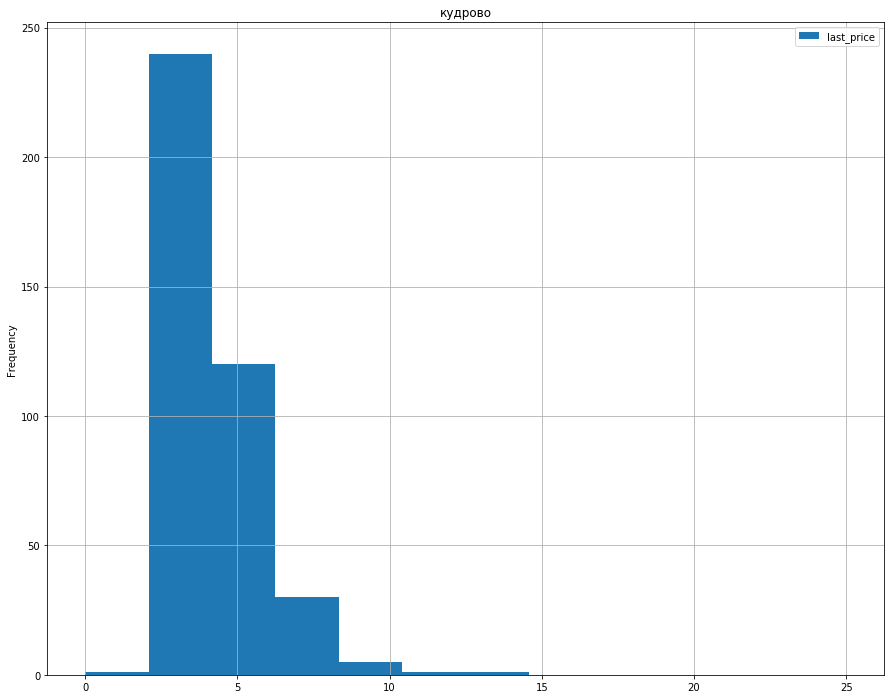

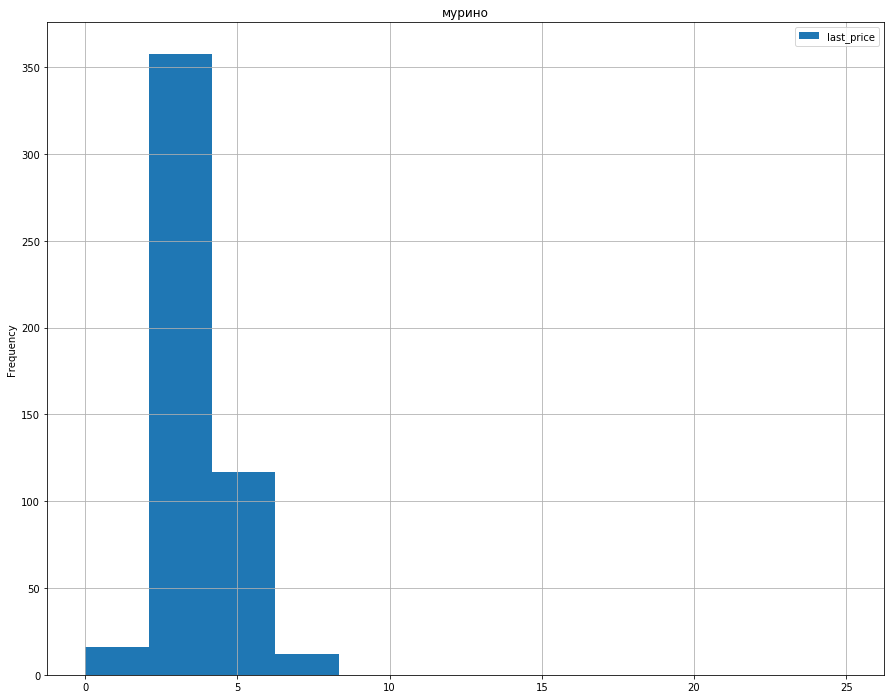

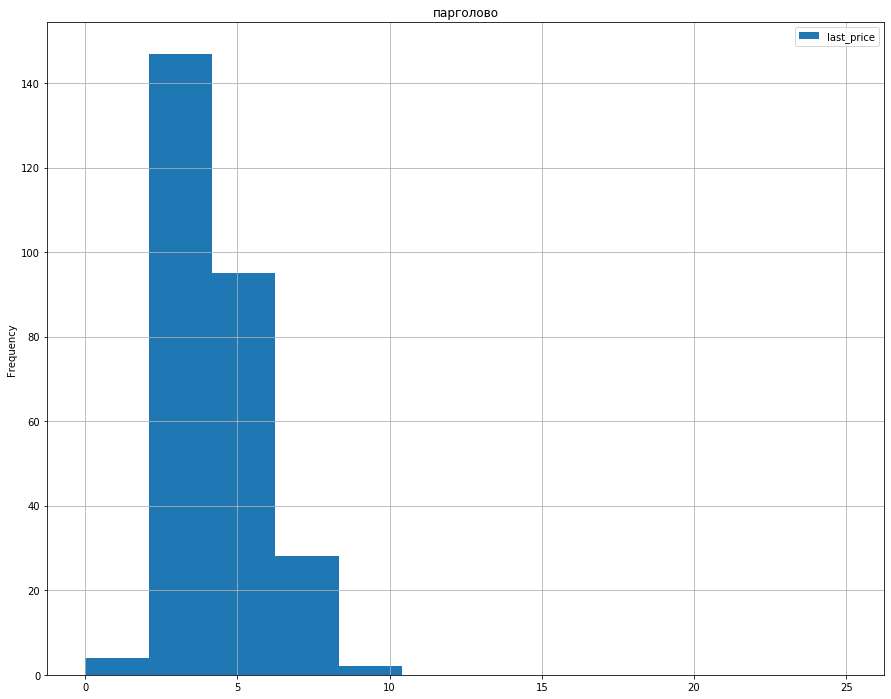

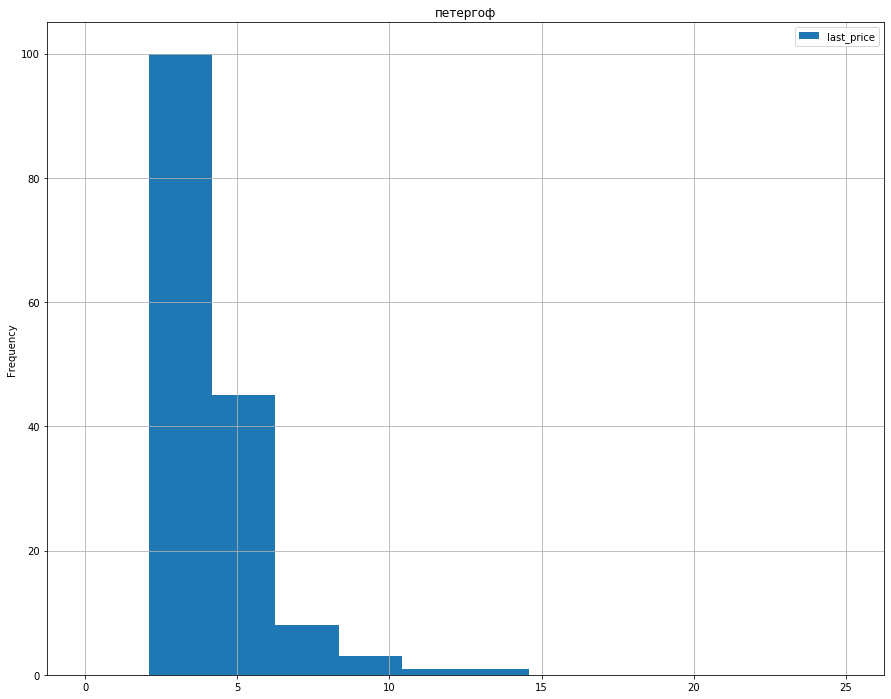

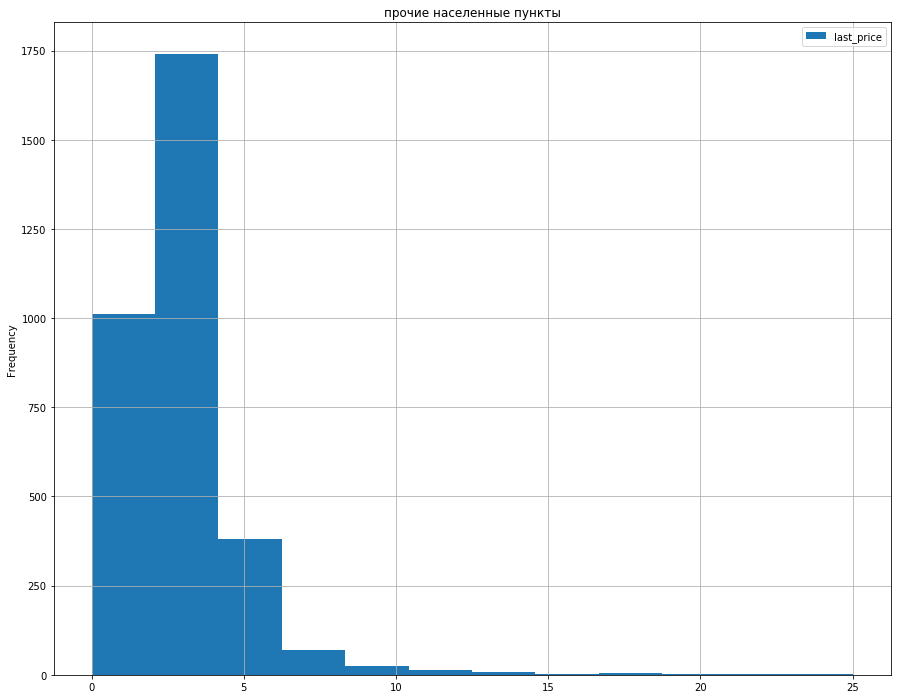

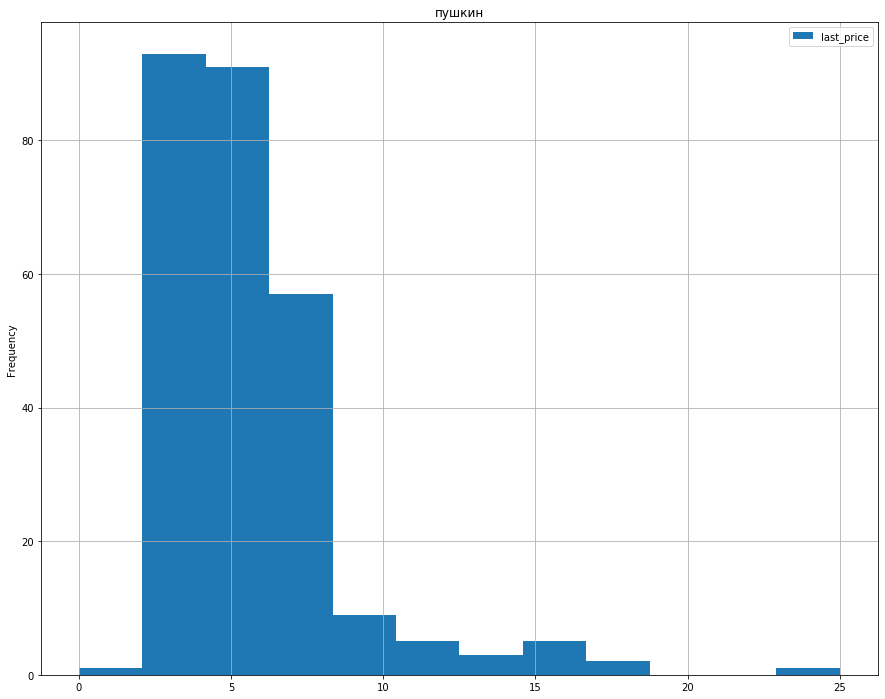

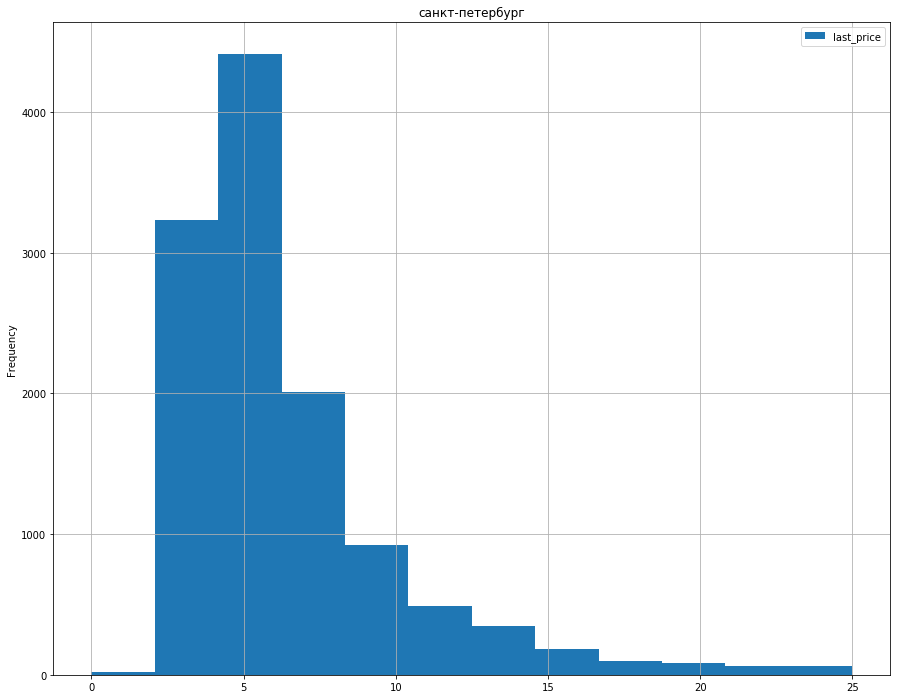

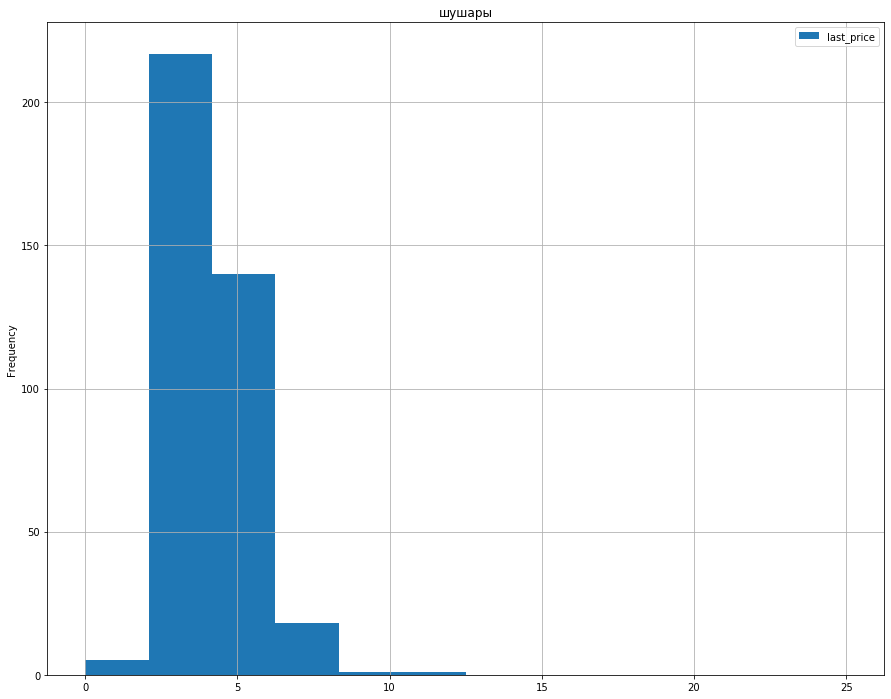

In [13]:
data_formated.pivot_table(index = 'total_area', values = 'last_price' , aggfunc = 'count').plot(title = 'total_area',
                                kind = 'hist', grid = True, bins = 100, figsize = (15, 12))
plt.show()
data_formated.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'count').plot(title = 'rooms',
                                kind = 'hist', grid = True, range = (0, 100), figsize = (15, 12))
plt.show()
for floor, group_data in data_formated.groupby('floor_mark'):
    group_data.plot(y = 'last_price', title = floor, kind = 'hist', bins = 50, 
                    range = (0, 100), grid = True, figsize = (15, 12))
plt.show()
data_formated.pivot_table(index = 'cityCenters_nearest', values = 'last_price', aggfunc = 'count').plot(title = 'center nearest',
                                kind = 'hist', grid = True, range = (0, 100), figsize = (15, 12))
plt.show()
data_formated.pivot_table(index = 'weekday_published', values = 'last_price', aggfunc = 'count').plot(title = 'weekday published',
                                kind = 'hist', grid = True, figsize = (15, 12))
plt.show()
data_formated.pivot_table(index = 'month_published', values = 'last_price', aggfunc = 'count').plot(title = 'month published',
                                kind = 'hist', grid = True, figsize = (15, 12))
plt.show()
data_formated.pivot_table(index = 'year_published', values = 'last_price', aggfunc = 'count').plot(title = 'year published',
                                kind = 'hist', grid = True, figsize = (15, 12))
plt.show()
data_formated.groupby('locality_name')['last_price'].plot(title = 'locality name',
                                kind = 'hist', range = (0, 10), grid = True, legend = True, bins = 11, figsize = (15, 12))
plt.show()

for name, data_grouped in data_formated.groupby('locality_name'):
    data_grouped.plot(y = 'last_price', title = name, kind = 'hist', bins = 12, range = (0, 25),grid = True, figsize = (15, 12))
    plt.show()


Меньше всего на стоимость квартиры влияет этаж, для всех этажей наиболее продаваемые квартиры сосредоточились вокруг одной цены. 
Больше всего влияет площадь, чем она выше, тем квартира будет дороже.

In [14]:
mean_price_data = data_formated.pivot_table(index = 'locality_name', values = 'last_price')
mean_area_data =  data_formated.pivot_table(index = 'locality_name', values = 'total_area')
mean_cities_data = mean_price_data.join(mean_area_data)
mean_cities_data.set_axis(['last_price_mean_mln_rub', 'total_area_mean'],axis = 'columns', inplace = True)
mean_cities_data['mean_price_per_meter_rub'] = (mean_cities_data['last_price_mean_mln_rub']/mean_cities_data['total_area_mean'])*1000000 
display(mean_cities_data)


,last_price_mean_mln_rub,total_area_mean,mean_price_per_meter_rub
locality_name,,,
всеволожск,3.687211,54.472922,67688.876816
выборг,3.047068,53.883158,56549.551661
гатчина,3.409637,50.819072,67093.657320
колпино,3.930973,53.384930,73634.501943
кудрово,4.295730,46.155126,93071.573250
мурино,3.616156,43.278330,83555.800358
парголово,4.405342,51.348406,85793.164839
петергоф,4.046722,49.056013,82491.855732
прочие населенные пункты,2.965867,50.928478,58235.922581


Самый дорогой для жизни город Санкт-Петербург, средняя цена квадратного метра составляет примерно 121 тысячу рублей. Вторым в списке идет Пушкин, за ним Кудрово. Самыми дешевыми для жизни оказались областные города с маленьким количеством объявлений, средняя цена квадратного метра в области составила 58 тысяч рублей.

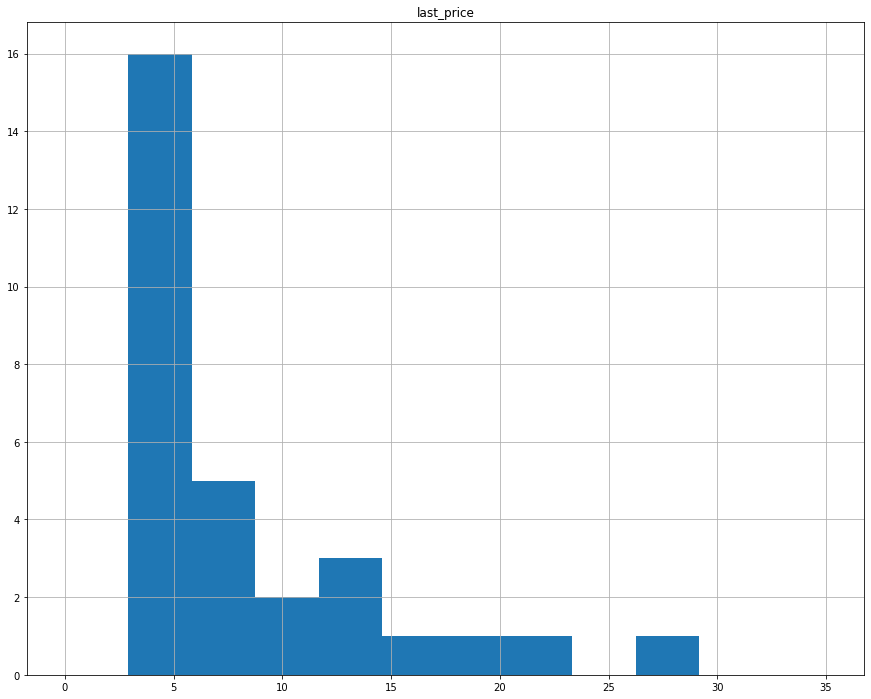

cityCenters_nearest
0.0     28.961250
1.0     20.469311
2.0     18.117010
3.0     10.116247
4.0     13.203449
5.0     13.635372
6.0     14.589106
7.0     13.105911
8.0      9.570560
9.0      6.615164
10.0     6.154368
11.0     5.984017
12.0     5.599393
13.0     5.928279
14.0     5.469719
15.0     5.590636
16.0     5.188321
17.0     5.161596
18.0     5.037890
19.0     4.859855
20.0     5.252284
21.0     5.172489
22.0     5.147364
23.0     4.590000
24.0     3.835887
25.0     4.052840
26.0     3.907444
27.0     8.300000
28.0     5.026429
29.0     4.050000
Name: last_price, dtype: float64

count    30.000000
mean      8.423073
std       5.880618
min       3.835887
25%       5.065258
50%       5.595014
75%       9.979825
max      28.961250
Name: last_price, dtype: float64

In [15]:
i = data_formated[data_formated['cityCenters_nearest'].isna()].index
data_formated_spb = data_formated.query('index not in @i and locality_name == "санкт-петербург"')
data_formated_spb['cityCenters_nearest'] = round(data_formated_spb['cityCenters_nearest']/1000)

data_formated_spb.pivot_table(index = 'cityCenters_nearest', 
                     values = 'last_price', aggfunc = 'mean').hist(bins = 12, range = (0, 35), figsize = (15, 12))
plt.show()
data__formated_spb_grouped = data_formated_spb.groupby('cityCenters_nearest')['last_price'].mean()
display(data__formated_spb_grouped)
display(data__formated_spb_grouped.describe())


Как и ожидалось, чем ближе к центру - тем дороже. Самый дорогой километр - нулевой, самый дешевый - 24ый. Наблюдается интересный выброс цены на 4м и 5м км, а так же 27м. Если первые два выброса в пределах допустимоного, то последний - интересное наблюдение. Возмонжно это говорит нам о наличии какого-то района с домами более высокого класса, нежели среднеценовой сегмент.

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_prise,weekday_published,month_published,year_published,floor_mark,living_area_in_percent,kitchen_area_in_percent
3,0,64.90,159.0,2015-07-24,3,2.6,14,88.7,9,True,False,False,27.5,0,санкт-петербург,28098.0,7.0,2.0,84.0,3.0,234.0,424,0.4,4,7,2015,другой,55.79,17.30
24,8,6.50,97.2,2015-10-31,2,2.6,3,46.5,1,True,False,False,19.6,0,санкт-петербург,20052.0,2.0,3.0,411.0,3.0,124.0,265,0.1,5,10,2015,первый,47.84,20.16
51,7,45.00,161.0,2017-10-17,3,3.2,8,38.0,4,True,False,False,50.0,0,санкт-петербург,32537.0,7.0,0.0,NaN,3.0,99.0,541,0.3,1,10,2017,другой,23.60,31.06
63,2,20.00,118.0,2018-09-11,3,3.0,9,68.0,7,True,False,False,16.0,0,санкт-петербург,26055.0,5.0,1.0,648.0,1.0,779.0,37,0.2,1,9,2018,другой,57.63,13.56
99,32,9.60,90.0,2017-09-26,4,2.6,5,67.0,2,True,False,False,8.0,0,санкт-петербург,23277.0,3.0,0.0,NaN,0.0,NaN,104,0.1,1,9,2017,другой,74.44,8.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23644,7,4.99,62.5,2018-04-26,2,2.7,4,32.3,4,True,False,False,12.1,0,санкт-петербург,20141.0,4.0,1.0,560.0,1.0,171.0,166,0.1,3,4,2018,последний,51.68,19.36
23665,11,4.25,47.0,2016-05-20,1,2.6,6,18.2,1,False,False,False,14.6,0,санкт-петербург,20503.0,5.0,2.0,624.0,1.0,519.0,131,0.1,4,5,2016,первый,38.72,31.06
23681,13,5.25,43.0,2018-05-11,2,2.5,5,29.0,2,True,False,False,6.0,0,санкт-петербург,28323.0,7.0,1.0,497.0,2.0,660.0,80,0.1,4,5,2018,другой,67.44,13.95
23690,3,5.50,52.0,2018-07-19,2,2.6,5,31.0,2,True,False,False,6.0,0,санкт-петербург,20151.0,6.0,1.0,300.0,0.0,NaN,15,0.1,3,7,2018,другой,59.62,11.54


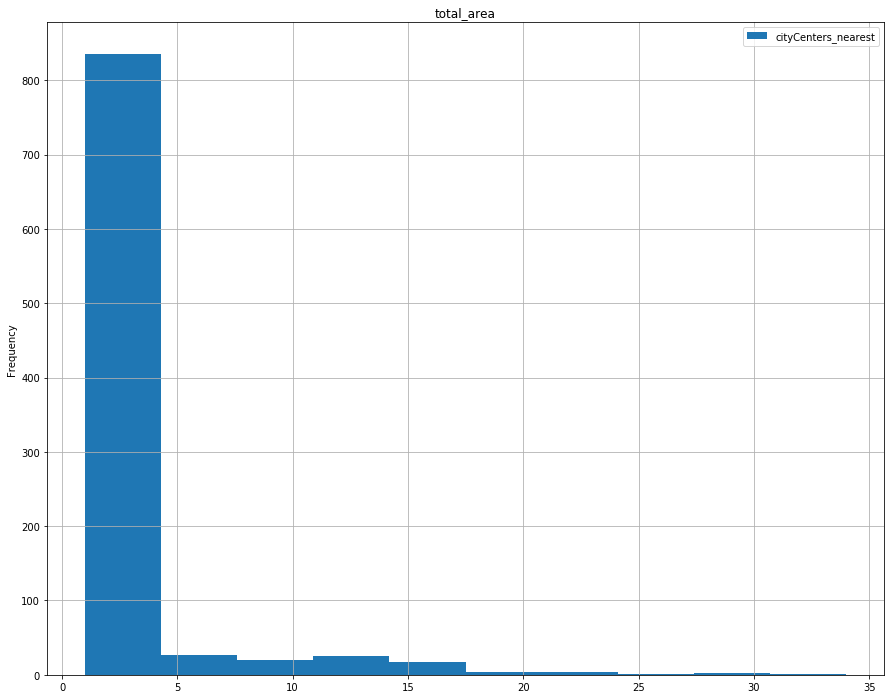

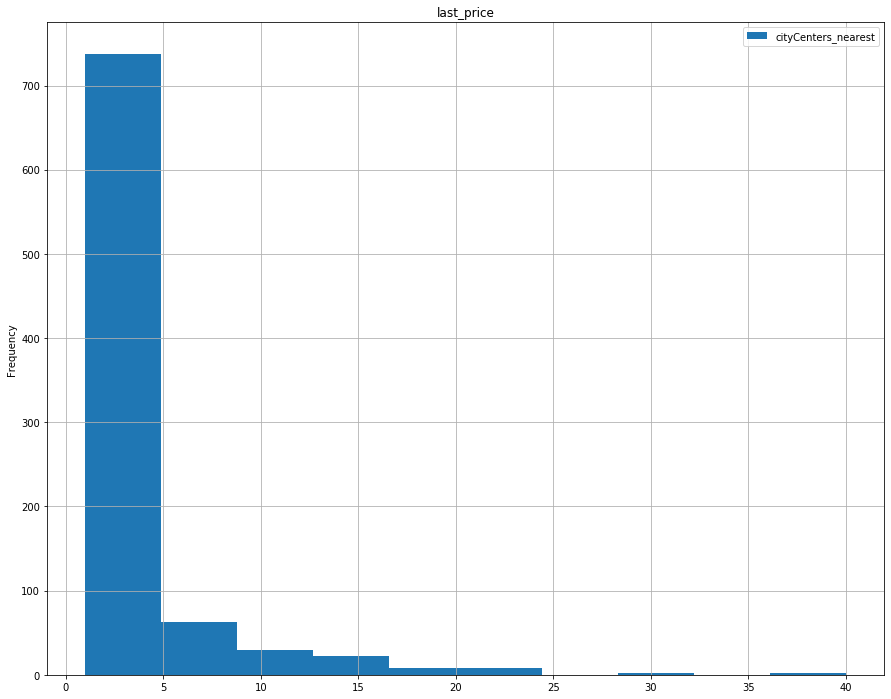

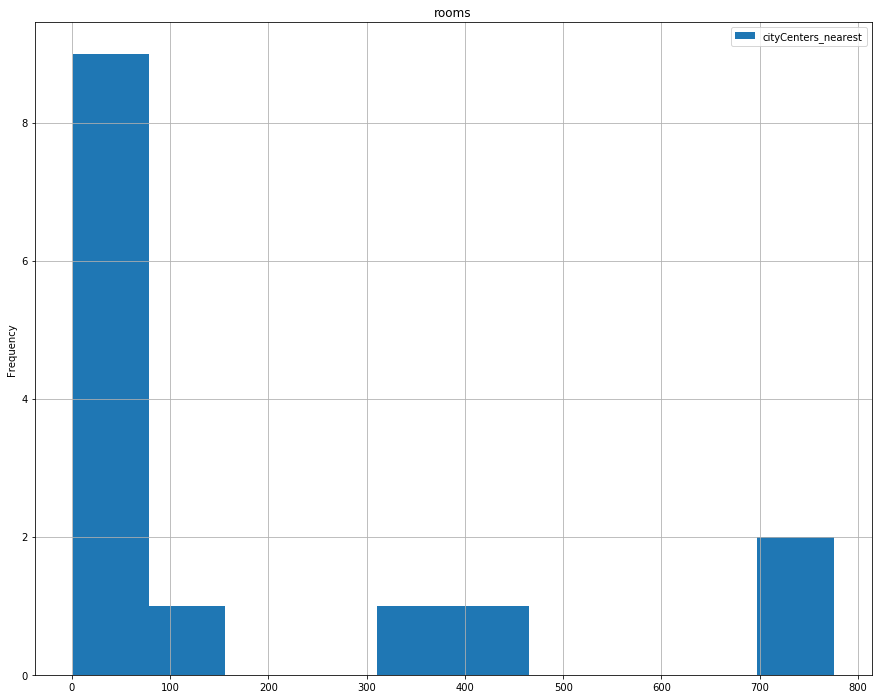

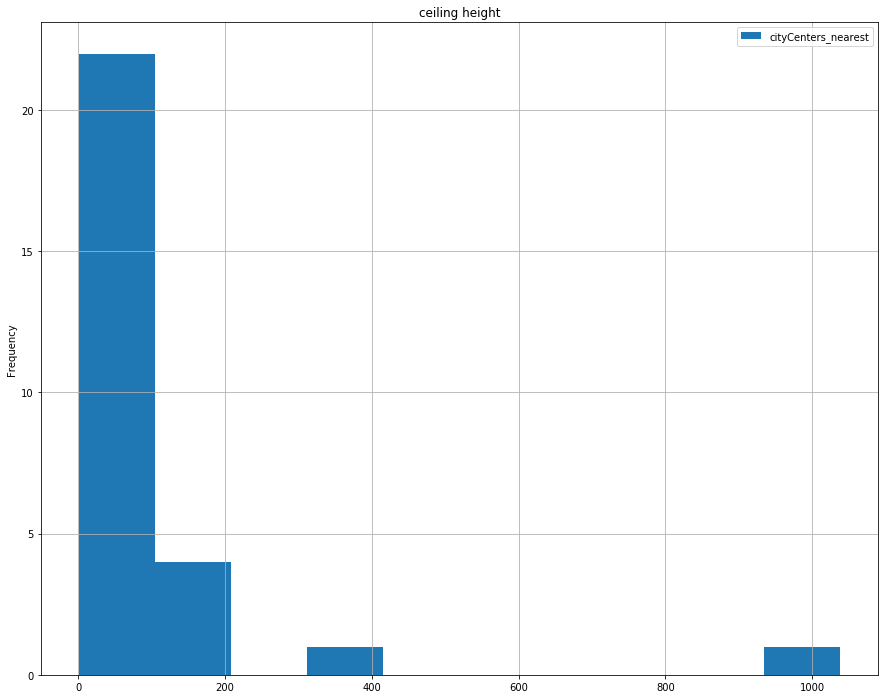

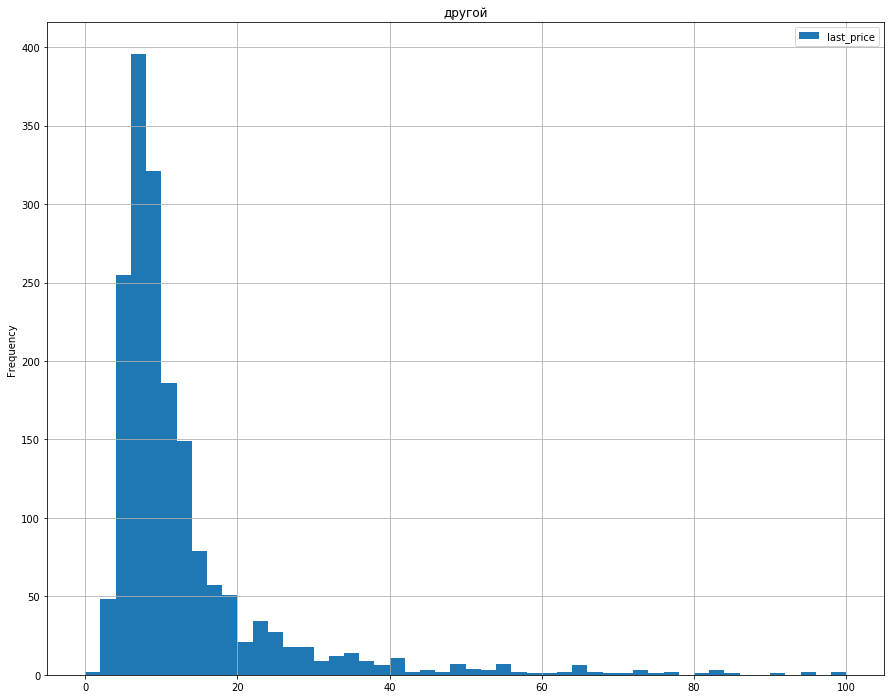

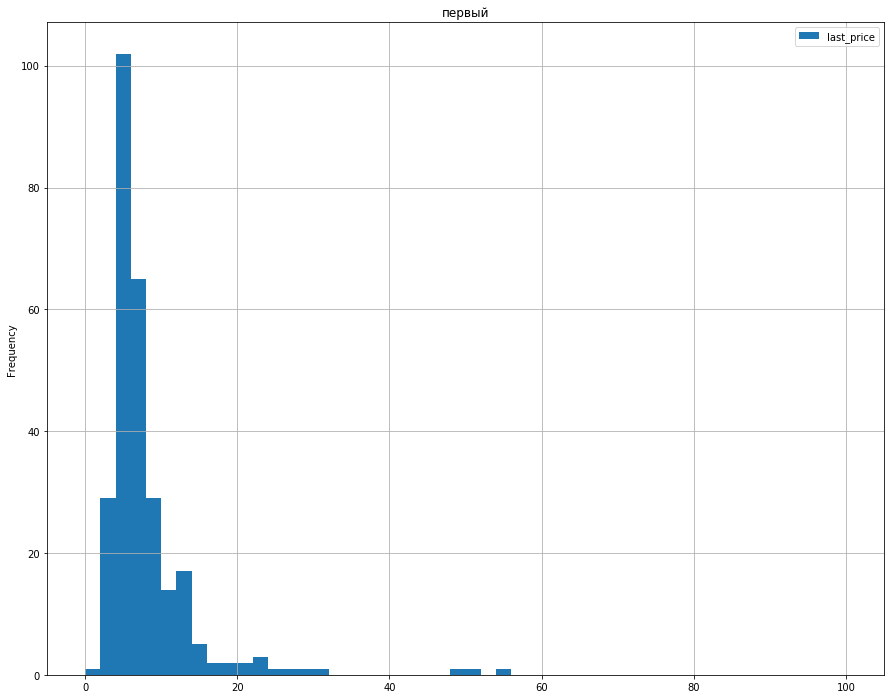

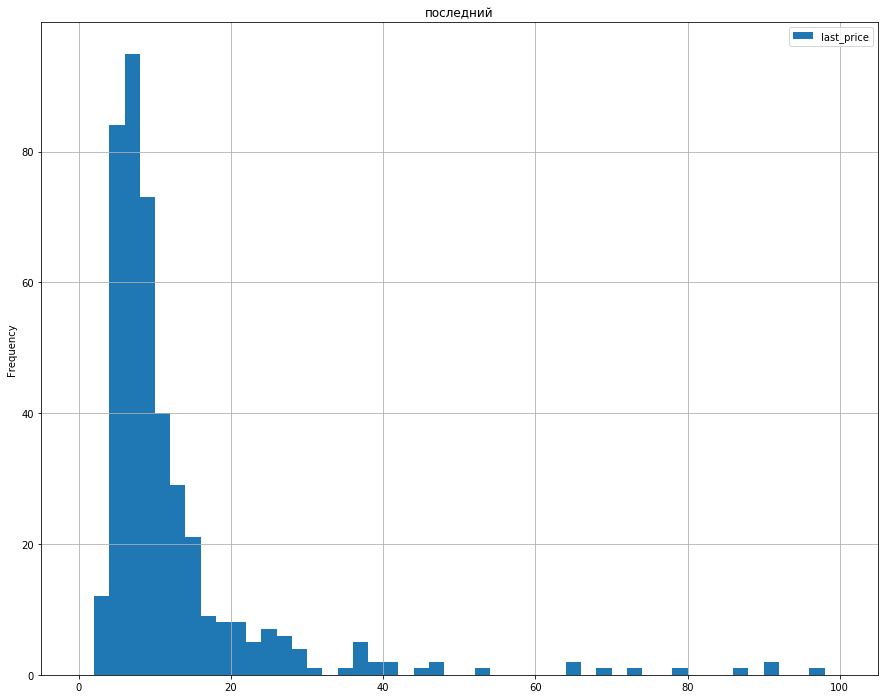

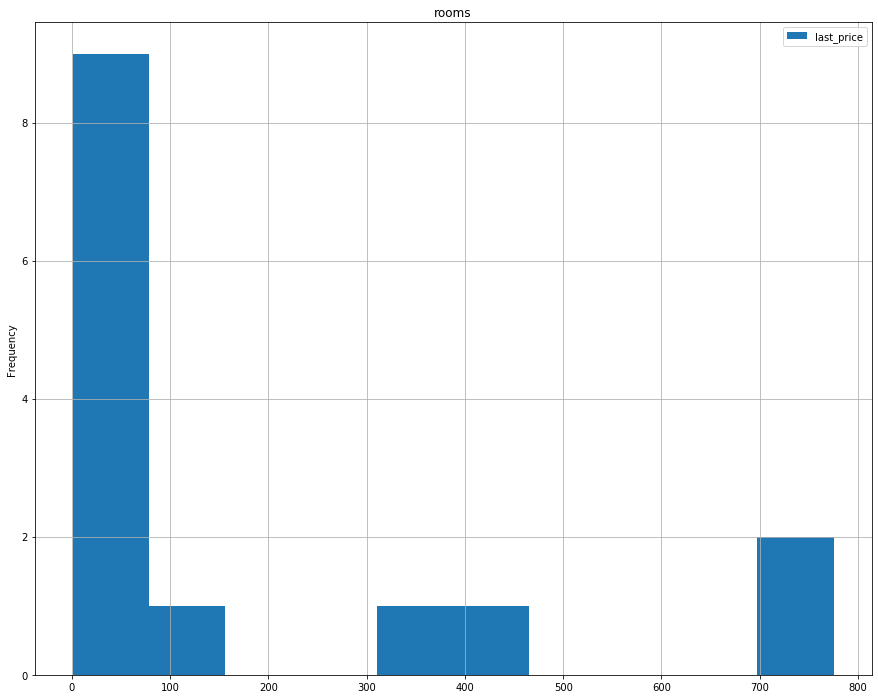

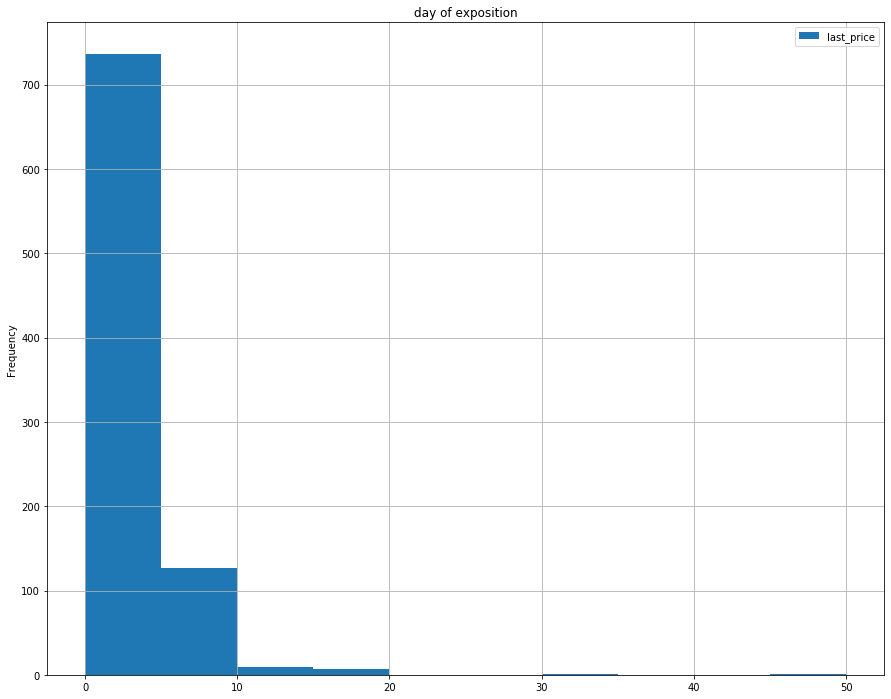

In [16]:
data_new_grouped_centers = data_formated_spb.query('cityCenters_nearest <= 7')
display(data_new_grouped_centers)
data_new_grouped_centers.pivot_table(index = 'total_area', values = 'cityCenters_nearest', aggfunc = 'count').plot(title = 'total_area',
                                kind = 'hist', grid = True, figsize = (15, 12))
plt.show()
data_new_grouped_centers.pivot_table(index = 'last_price', values = 'cityCenters_nearest', aggfunc = 'count').plot(title = 'last_price',
                                kind = 'hist', grid = True, figsize = (15, 12))
plt.show()
data_new_grouped_centers.pivot_table(index = 'rooms', values = 'cityCenters_nearest', aggfunc = 'count').plot(title = 'rooms',
                                kind = 'hist', grid = True, figsize = (15, 12))
plt.show()
data_new_grouped_centers.pivot_table(index = 'ceiling_height', values = 'cityCenters_nearest', aggfunc = 'count').plot(title = 'ceiling height',
                                kind = 'hist', grid = True, figsize = (15, 12))
plt.show()

for floor, group_data in data_new_grouped_centers.groupby('floor_mark'):
    group_data.plot(y = 'last_price', title = floor, kind = 'hist', bins = 50, 
                    range = (0, 100), grid = True, figsize = (15, 12))
plt.show()
data_new_grouped_centers.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'count').plot(title = 'rooms',
                                kind = 'hist', grid = True, figsize = (15, 12))
plt.show()
data_new_grouped_centers.pivot_table(index = 'first_day_exposition', values = 'last_price', aggfunc = 'count').plot(title = 'day of exposition',
                                kind = 'hist', grid = True, range = (0, 50), figsize = (15, 12))
plt.show()

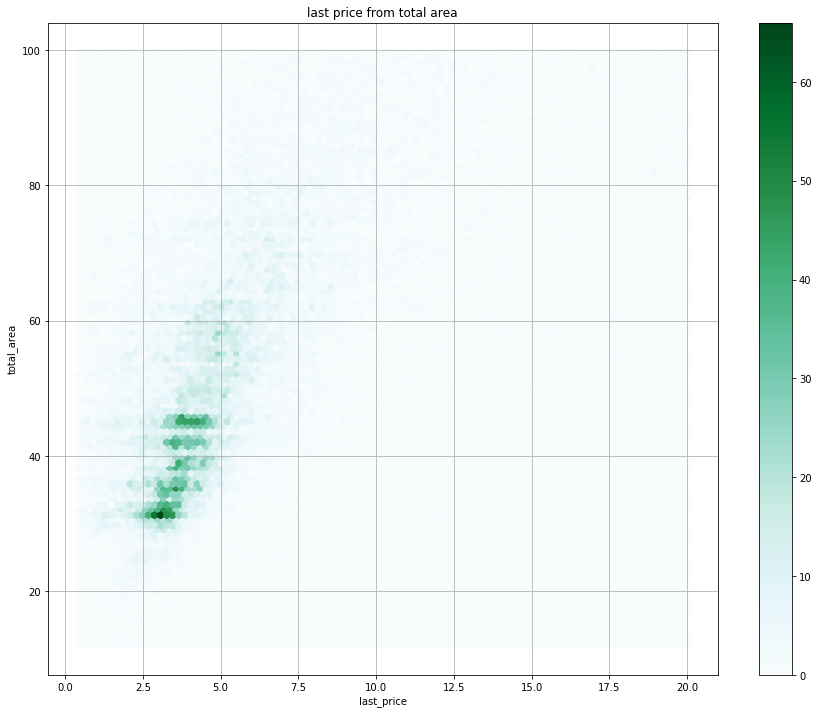

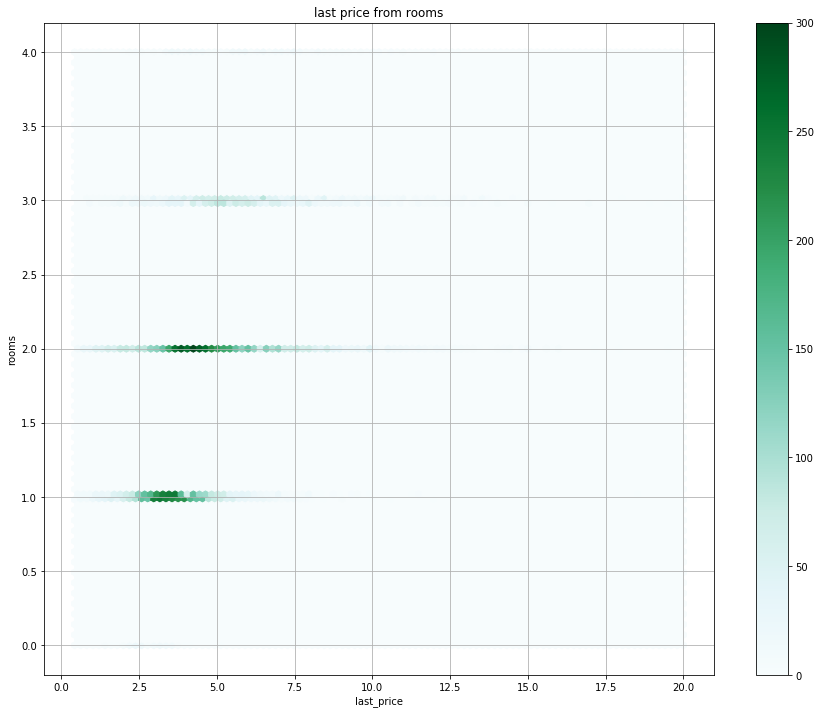

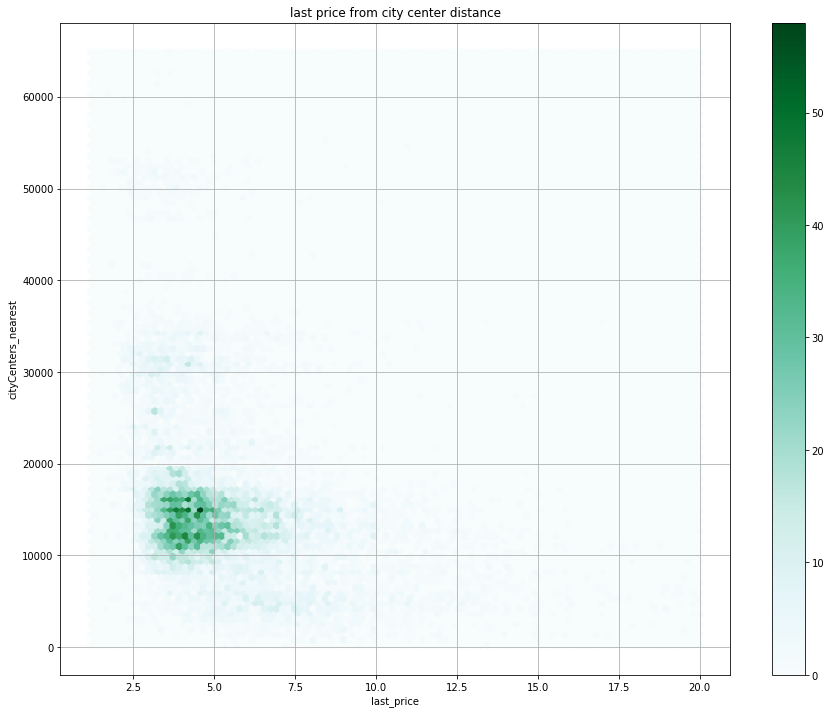

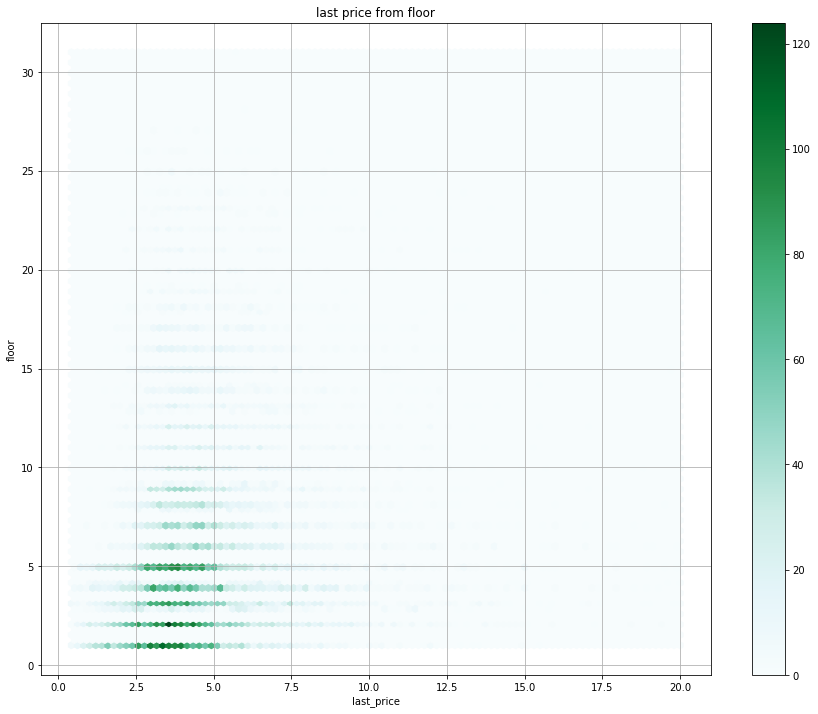

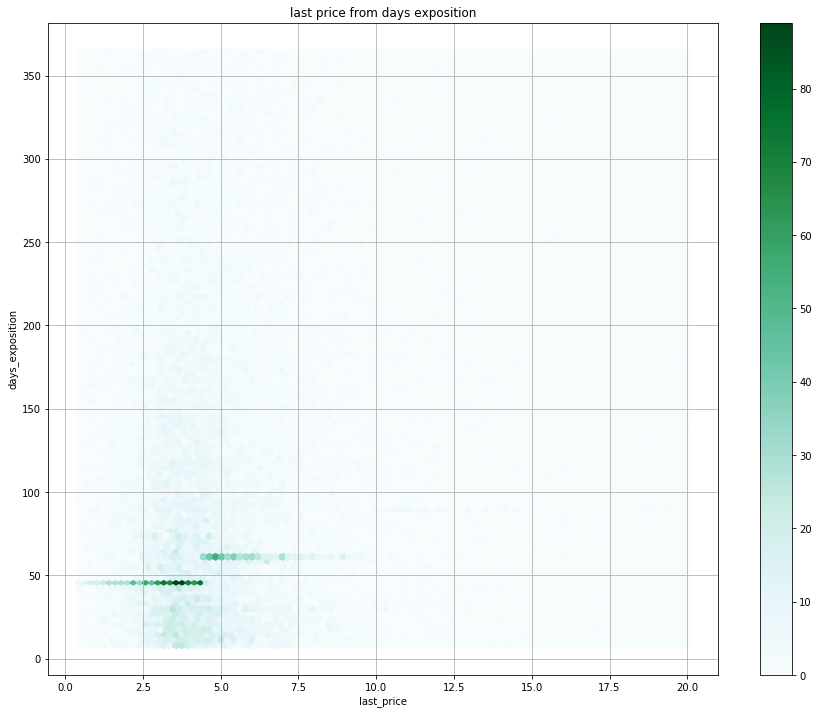

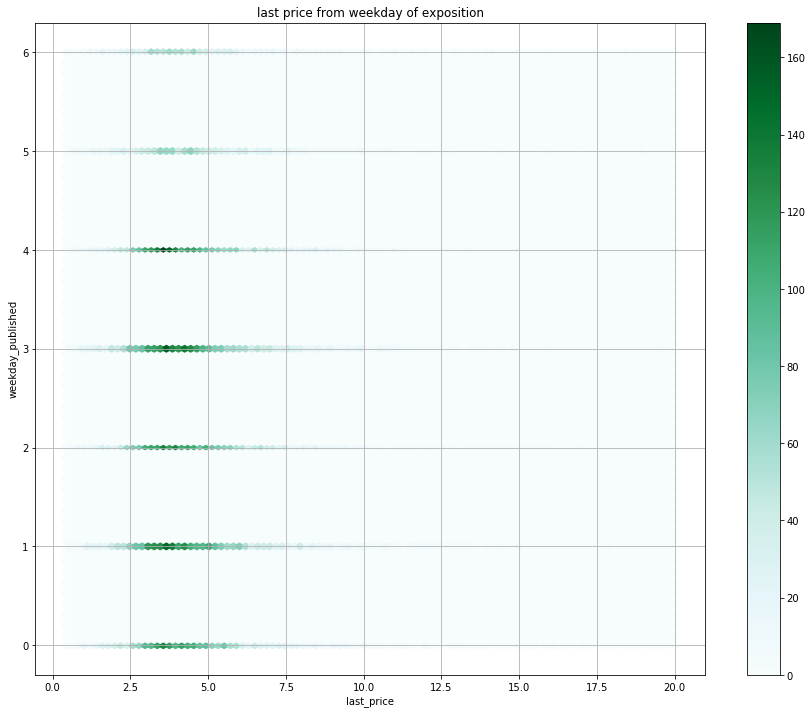

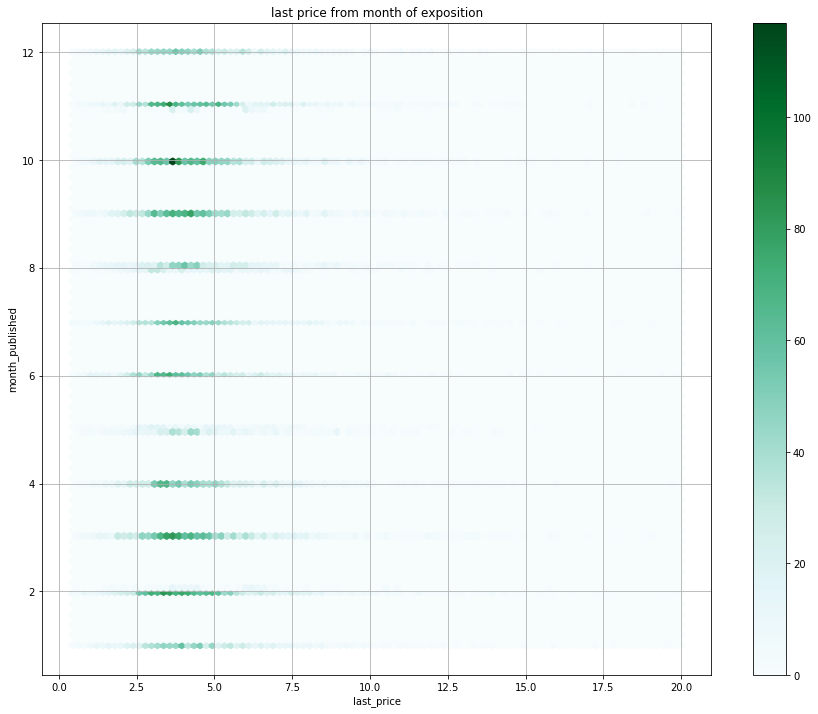

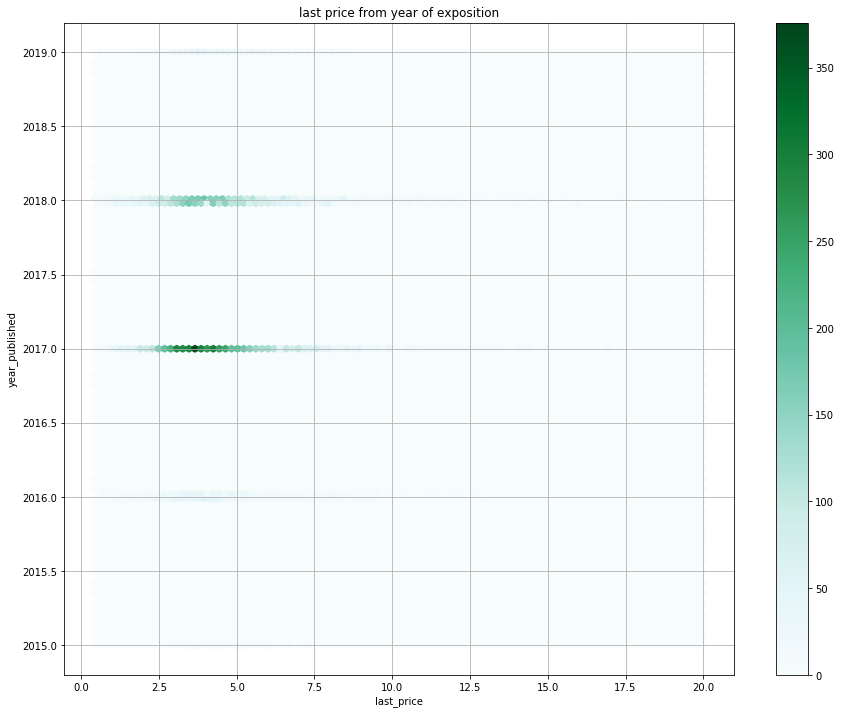

In [17]:
data_formated_normal_price = data_formated.query('last_price < 20 and total_area < 100 and rooms < 5 and days_exposition < 365')
data_formated_normal_price.plot(x = 'last_price', y = 'total_area', kind = 'hexbin',
                    title = 'last price from total area', gridsize = 100, sharex = False, grid = True, figsize = (15, 12))
plt.show()
data_formated_normal_price.plot(x = 'last_price', y = 'rooms', kind = 'hexbin',
                                title = 'last price from rooms', gridsize = 100, sharex = False, grid = True, figsize = (15, 12))
plt.show()
data_formated_normal_price.plot(x = 'last_price', y = 'cityCenters_nearest', kind = 'hexbin',
                                title = 'last price from city center distance', gridsize = 100, sharex = False, grid = True, figsize = (15, 12))
plt.show()
data_formated_normal_price.plot(x = 'last_price', y = 'floor', kind = 'hexbin',
                                title = 'last price from floor', gridsize = 100, sharex = False, grid = True, figsize = (15, 12))
plt.show()
data_formated_normal_price.plot(x = 'last_price', y = 'days_exposition', kind = 'hexbin',
                                title = 'last price from days exposition', gridsize = 100, sharex = False, grid = True, figsize = (15, 12))
plt.show()
data_formated_normal_price.plot(x = 'last_price', y = 'weekday_published', kind = 'hexbin',
                                title = 'last price from weekday of exposition', gridsize = 100, sharex = False, grid = True, figsize = (15, 12))
plt.show()
data_formated_normal_price.plot(x = 'last_price', y = 'month_published', kind = 'hexbin',
                                title = 'last price from month of exposition',gridsize = 100, sharex = False, grid = True, figsize = (15, 12))
plt.show()
data_formated_normal_price.plot(x = 'last_price', y = 'year_published', kind = 'hexbin',
                                title = 'last price from year of exposition', gridsize = 100, sharex = False, grid = True, figsize = (15, 12))
plt.show()


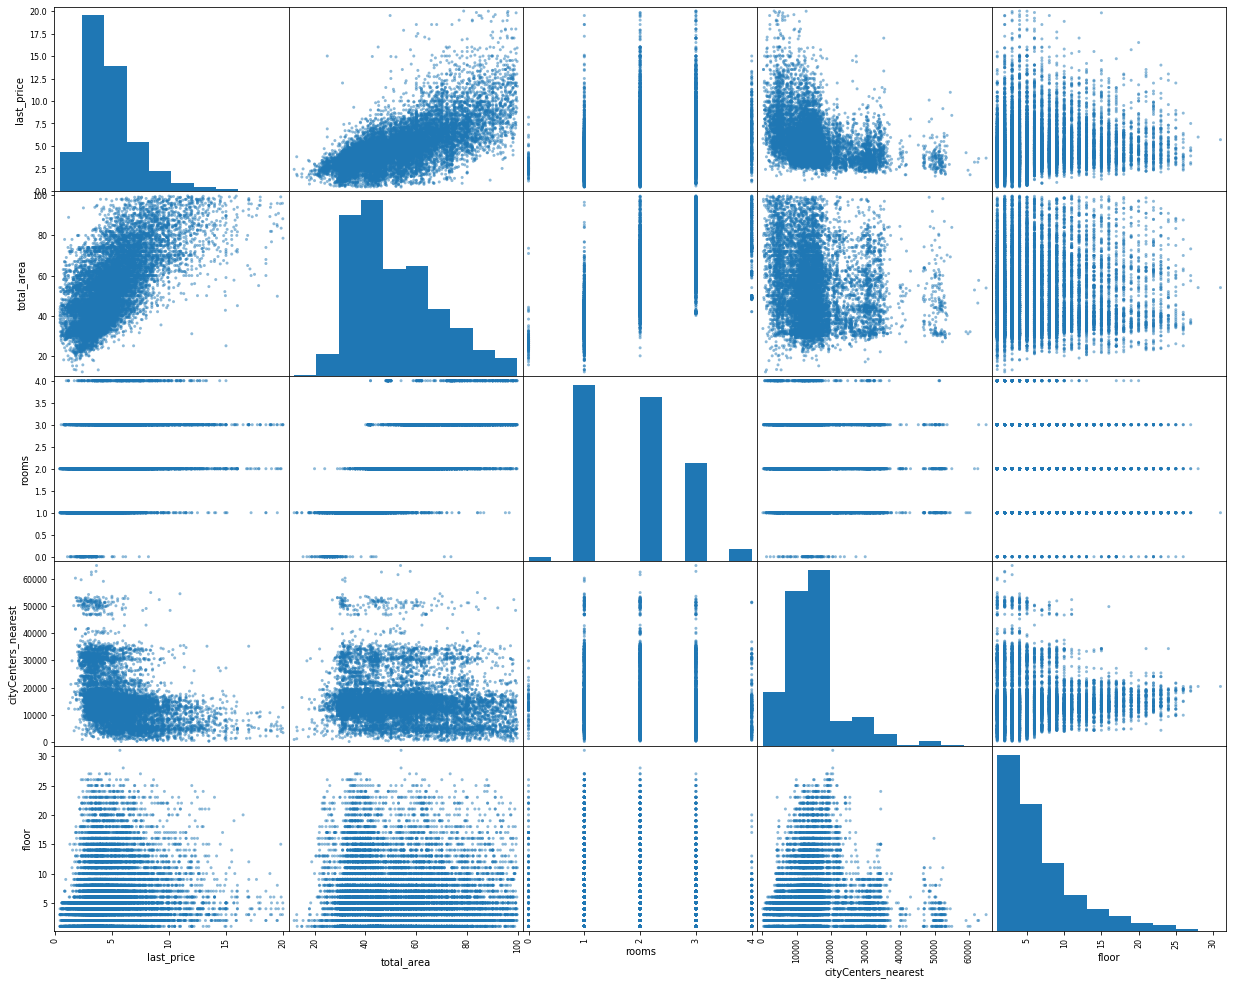

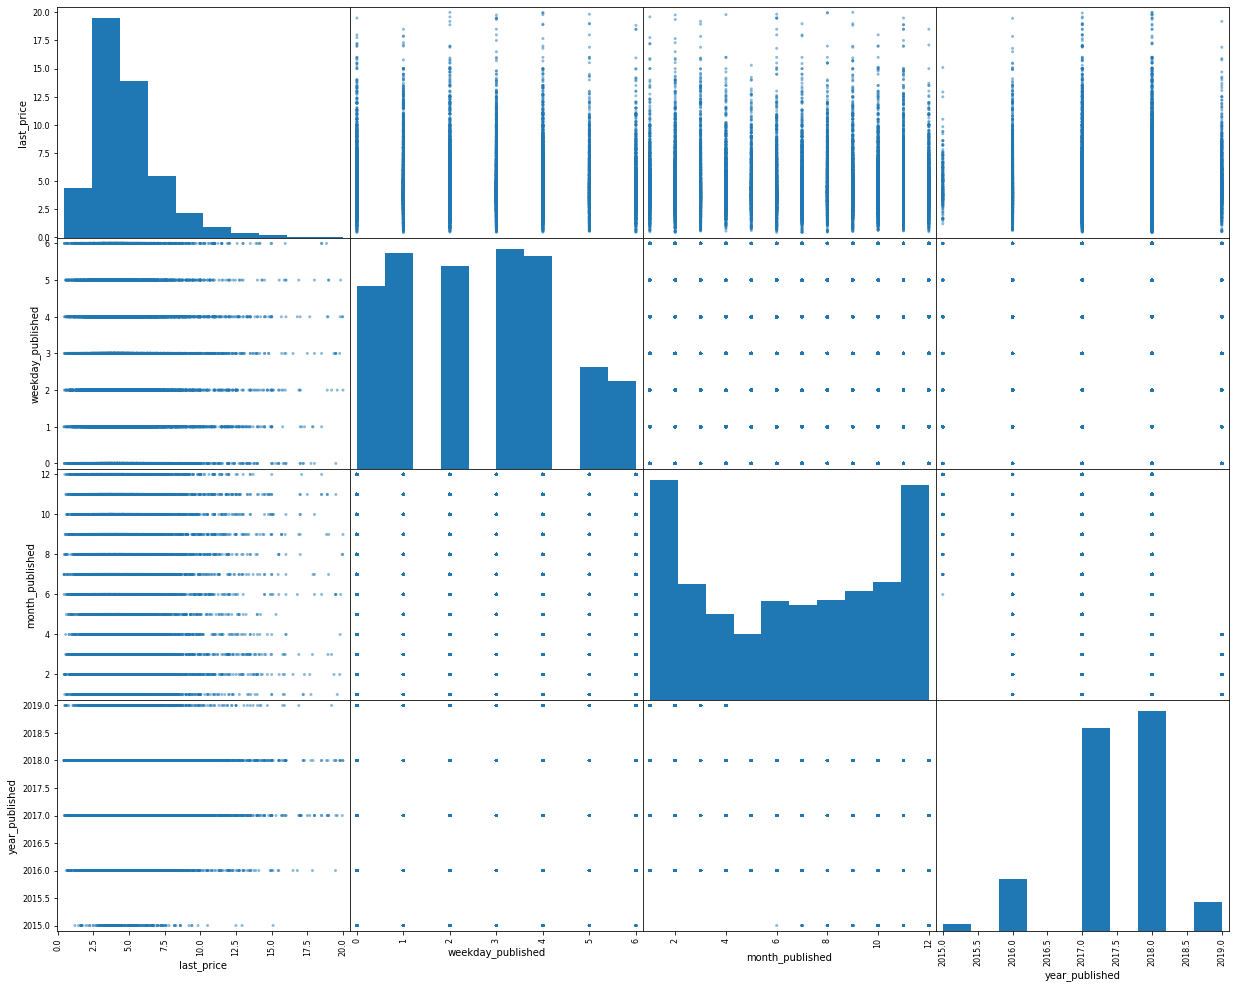

In [18]:
pd.plotting.scatter_matrix(data_formated_normal_price[['last_price', 'total_area',
        'rooms','cityCenters_nearest', 'floor']],
        alpha=0.5, figsize=(21,17), grid = True, diagonal='hist')
plt.show()
pd.plotting.scatter_matrix(data_formated_normal_price[['last_price','weekday_published',
        'month_published', 'year_published']],
        alpha=0.5, figsize=(21,17), grid=True, diagonal='hist')
plt.show()

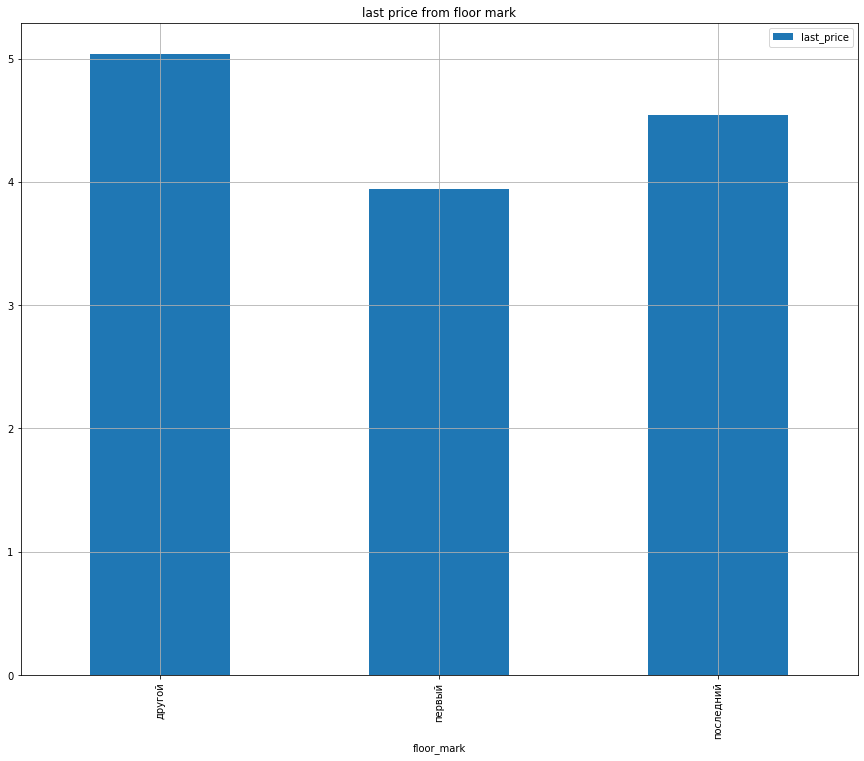

In [19]:
data_formated_normal_price.pivot_table(index = 'floor_mark', values = 'last_price').plot(kind = 'bar', 
                                title = 'last price from floor mark', grid = True, figsize = (15,12))
plt.show()

Чтобы уточнить наши результаты и сделать их более наглядными сделаем срез по форматированным данным вокруг самых популярных, согласно нашей гипотезе, вариантов. Полученные зависимости наглядно отображают верность выдвиннутого тезиса - самые продаваемые квартиры стоили от 2,5 до 6 млн руб, были от 30 до 60 квадратных метров, что соответствует формату одно и двухкомнатных квартир, находились в некоторой удаленности от центра(Петербург не такой уж и большой город и радиус в 15 км от центра намекает, что такие квартиры, скорее всего, находятся в спальных районах) и располагались до 5го этажа (в редких случаях до 10го). На продажу таких квартир в среднем уходило до 2х месяцев, что можно считать вполне правдоподобными данными. Больше всего на цену влияют площади и количество комнат, в меньшей степени этаж и удаленность от центра. В будни люди публикуют объявления гораздо чаще, наибольшее количество объявлений размещено с понедельника по среду.Самый активный месяц - октябрь. Самый богатый на продажу недвижимости год - 2017. И вновь большая часть объвлений - квартиры стоимостью до 5млн. Что же касается этажа - самыми дешевыми предложениями оказались объявления о квартирах на первом этаже. Последний этаж на втором месте по средней стоимости, самыми дорогими предложения на "других" этажах.

In [20]:
data_formated_normal_price[['last_price','total_area', 'rooms','cityCenters_nearest', 'floor', 
    'weekday_published', 'month_published', 'year_published']].corr()['last_price'].reset_index()
    .sort_values(by='last_price', ascending=False)


,index,last_price
0,last_price,1
1,total_area,0.688616
2,rooms,0.403326
4,floor,0.127422
7,year_published,0.0133653
6,month_published,0.00183383
5,weekday_published,-0.00698578
3,cityCenters_nearest,-0.345481


Ситуация в центре Петербурга несколько отличается от общей. Начнем с того, что чаще всего, объявления о продаже квартир в центе имею большую площадь, чем в среднем. Цена также выше, и сильно. Разница в этих двух величинах идет на порядки.
Более того, в центре почти отсутствуют объявленияо продаже квартир с небольшим количеством комнат, тут преобладают квартиры многокомнатные, а двух и трехкомнатные для такой выборки больше похоже на анамальное отклонение.Ситуация с высотой потолков подтверждает это - самая распространенная высота потолков стремится к 4,5ти метрам, что похоже на правду - центр Петербурга наполнен домами старого фонда(не хрущевками, а историческими зданиями) с очень высокими потолками. Так же на графиках видно, что квартиры на последнем этаже в центре продаются реже всего, зато на первых этажах чаще. Больше всего предложений на непервом этаже. В среднем, в обоих случаях, цена на наиболее популярные предложения колеблется в районе 8ми млн. На последнем графике видно, что в центре самые популярные объявления колеблются в районе 10 млн, что аналогичным образом выбивается из средней тенденции. Можно утверждать, что данные по центру не укладываются в усредненную гипотезу по общей выборке.

### Шаг 5. Общий вывод

Самой дорогой недвижимостью оказались объекты вокруг центра Петербурга с большой площадью и высотой потолков. Самыми недорогими вариантами оказались квартиры в области в городах, с меньшим количеством объявлений. В целом прослеживается тренд на однокомнатные и двухкомнатные квартиры стоимостью до 8ми млн площадью 40-60 квадратных метров.